## Train Model

In [1]:
import os
import logging
from datetime import datetime
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
# Import the sb3 monitor for logging 
from stable_baselines3.common.monitor import Monitor
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from SimpleWalk2D import SimpleWalk2DDynGoal

env = SimpleWalk2DDynGoal()
env = Monitor(env)

In [2]:
print('Date and time:', datetime.now().strftime('%Y-%m-%d_%H%M'))

Date and time: 2022-02-24_1626


### Train Callback

In [3]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

### Optuna


In [4]:
# Importing the optimzation frame - HPO
import optuna
# PPO algo for RL
from stable_baselines3 import PPO
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy

# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# Import os to deal with filepaths
import os


# Function to return test hyperparameters - define the object function

now = datetime.now().strftime('%Y-%m-%d_%H%M')

LOG_DIR = './train/logs/' + now + '/'
OPT_DIR = './train/opt/'+ now + '/'

def optimize_ppo(trial): 
    return {
        'n_steps':trial.suggest_int('n_steps', 256, 8192, 64),
        'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range':trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda':trial.suggest_uniform('gae_lambda', 0.8, 0.99)
    }
    
SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(1))

# Run a training loop and return mean reward 
def optimize_agent(trial):
    
    # Get hyperparameters
    model_params = optimize_ppo(trial) 

    # Create environment 
    # env = SimpleWalk2DDynGoal()
    # env = Monitor(env)
    # env = DummyVecEnv([lambda: env])
    # env = VecFrameStack(env, 4, channels_order='last')

    # Create algo 
    model = PPO(
        'MlpPolicy', 
        env, 
        tensorboard_log=LOG_DIR, 
        verbose=0, 
        **model_params)
    model.learn(total_timesteps=100_000)
    #model.learn(total_timesteps=100000)

    # Evaluate model 
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=30)
    env.close()

    SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
    model.save(SAVE_PATH)

    return mean_reward

    
# Creating the experiment 
study = optuna.create_study(direction='maximize')
study.optimize(
    optimize_agent, 
    n_trials=1_000,
    timeout=60*60*12,
    show_progress_bar=True,
    )
#study.optimize(optimize_agent, n_trials=100, n_jobs=1)

study.best_params

study.best_trial

#model = PPO.load(os.path.join(OPT_DIR, 'trial_5_best_model.zip'))

print('Finished', datetime.now().strftime('%Y-%m-%d_%H%M'))

[I 2022-02-24 16:26:21,920] A new study created in memory with name: no-name-6786b65d-e341-4fd8-a4fc-d4fd642af5cc
/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  0%|          | 0/1000 [00:00<?, ?it/s]/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path 'train/opt/2022-02-24_1626' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
  0%|          | 1/1000 [02:23<39:42:08, 143.07s/it, 143.07/43200 seconds]

[I 2022-02-24 16:28:44,992] Trial 0 finished with value: -2157.1072072666666 and parameters: {'n_steps': 1280, 'gamma': 0.9671741855327916, 'learning_rate': 2.7547006266096863e-05, 'clip_range': 0.27269481214280733, 'gae_lambda': 0.9521983128794639}. Best is trial 0 with value: -2157.1072072666666.


  0%|          | 2/1000 [04:43<39:18:35, 141.80s/it, 283.98/43200 seconds]

[I 2022-02-24 16:31:05,901] Trial 1 finished with value: -636.8382066666667 and parameters: {'n_steps': 6272, 'gamma': 0.9998337292645633, 'learning_rate': 8.590543634362635e-05, 'clip_range': 0.11490090936230032, 'gae_lambda': 0.841598349272933}. Best is trial 1 with value: -636.8382066666667.


  0%|          | 3/1000 [06:59<38:24:51, 138.71s/it, 419.01/43200 seconds]

[I 2022-02-24 16:33:20,930] Trial 2 finished with value: -733.9276709666668 and parameters: {'n_steps': 1472, 'gamma': 0.8059279193021602, 'learning_rate': 1.7199933431752884e-05, 'clip_range': 0.21852669541165615, 'gae_lambda': 0.8337758951849495}. Best is trial 1 with value: -636.8382066666667.


  0%|          | 4/1000 [09:15<38:05:39, 137.69s/it, 555.14/43200 seconds]

[I 2022-02-24 16:35:37,060] Trial 3 finished with value: 1021.0220795000002 and parameters: {'n_steps': 3776, 'gamma': 0.884428514069264, 'learning_rate': 4.410721811011949e-05, 'clip_range': 0.30940054402565, 'gae_lambda': 0.8348440470592068}. Best is trial 3 with value: 1021.0220795000002.


  0%|          | 5/1000 [11:30<37:50:02, 136.89s/it, 690.60/43200 seconds]

[I 2022-02-24 16:37:52,522] Trial 4 finished with value: -1912.242432666667 and parameters: {'n_steps': 960, 'gamma': 0.9182951932721336, 'learning_rate': 2.205357530967352e-05, 'clip_range': 0.18390144687396742, 'gae_lambda': 0.946374767156648}. Best is trial 3 with value: 1021.0220795000002.


  1%|          | 6/1000 [13:47<37:47:01, 136.84s/it, 827.36/43200 seconds]

[I 2022-02-24 16:40:09,278] Trial 5 finished with value: -2232.1014104 and parameters: {'n_steps': 1408, 'gamma': 0.8269222198989693, 'learning_rate': 1.1081179798738694e-05, 'clip_range': 0.24584110516723914, 'gae_lambda': 0.8999443930661694}. Best is trial 3 with value: 1021.0220795000002.


  1%|          | 7/1000 [16:05<37:52:52, 137.33s/it, 965.70/43200 seconds]

[I 2022-02-24 16:42:27,623] Trial 6 finished with value: -1764.9292734 and parameters: {'n_steps': 5440, 'gamma': 0.9826094042758381, 'learning_rate': 1.8740102674831924e-05, 'clip_range': 0.32432031694712626, 'gae_lambda': 0.9099183890341472}. Best is trial 3 with value: 1021.0220795000002.


  1%|          | 8/1000 [18:24<37:57:50, 137.77s/it, 1104.41/43200 seconds]

[I 2022-02-24 16:44:46,335] Trial 7 finished with value: 783.1500354333333 and parameters: {'n_steps': 5760, 'gamma': 0.8208618378484951, 'learning_rate': 3.2368311190106086e-05, 'clip_range': 0.37355648798756413, 'gae_lambda': 0.9098909225563733}. Best is trial 3 with value: 1021.0220795000002.


  1%|          | 9/1000 [20:40<37:48:42, 137.36s/it, 1240.86/43200 seconds]

[I 2022-02-24 16:47:02,783] Trial 8 finished with value: -872.3742171999999 and parameters: {'n_steps': 5632, 'gamma': 0.9272724712435393, 'learning_rate': 3.148284253051899e-05, 'clip_range': 0.351205348407187, 'gae_lambda': 0.8481116410907198}. Best is trial 3 with value: 1021.0220795000002.


  1%|          | 10/1000 [22:55<37:32:43, 136.53s/it, 1375.53/43200 seconds]

[I 2022-02-24 16:49:17,455] Trial 9 finished with value: -1996.4601278666667 and parameters: {'n_steps': 3136, 'gamma': 0.8523714298086239, 'learning_rate': 2.5562660264328675e-05, 'clip_range': 0.3364950767415802, 'gae_lambda': 0.9812364334668654}. Best is trial 3 with value: 1021.0220795000002.


  1%|          | 11/1000 [25:16<37:51:46, 137.82s/it, 1516.29/43200 seconds]

[I 2022-02-24 16:51:38,210] Trial 10 finished with value: 1052.5029910666665 and parameters: {'n_steps': 8128, 'gamma': 0.8709682682465416, 'learning_rate': 5.8551251723875857e-05, 'clip_range': 0.3961867447474051, 'gae_lambda': 0.8045479526172895}. Best is trial 10 with value: 1052.5029910666665.


  1%|          | 12/1000 [27:39<38:15:50, 139.42s/it, 1659.38/43200 seconds]

[I 2022-02-24 16:54:01,297] Trial 11 finished with value: 831.7325475666665 and parameters: {'n_steps': 7680, 'gamma': 0.8788108965364193, 'learning_rate': 5.4583803783542846e-05, 'clip_range': 0.3997254917501299, 'gae_lambda': 0.800160228451503}. Best is trial 10 with value: 1052.5029910666665.


  1%|▏         | 13/1000 [29:55<37:55:37, 138.34s/it, 1795.21/43200 seconds]

[I 2022-02-24 16:56:17,129] Trial 12 finished with value: 774.5941848000002 and parameters: {'n_steps': 3520, 'gamma': 0.8728411142876054, 'learning_rate': 5.262841316196957e-05, 'clip_range': 0.29633152780415406, 'gae_lambda': 0.8013190110668651}. Best is trial 10 with value: 1052.5029910666665.


  1%|▏         | 14/1000 [32:11<37:43:20, 137.73s/it, 1931.54/43200 seconds]

[I 2022-02-24 16:58:33,456] Trial 13 finished with value: 984.7083244333335 and parameters: {'n_steps': 7424, 'gamma': 0.9146787906205986, 'learning_rate': 5.101427106518191e-05, 'clip_range': 0.38706244354861424, 'gae_lambda': 0.8691809390520949}. Best is trial 10 with value: 1052.5029910666665.


  2%|▏         | 15/1000 [34:20<36:55:14, 134.94s/it, 2060.01/43200 seconds]

[I 2022-02-24 17:00:41,928] Trial 14 finished with value: 1016.2042115000002 and parameters: {'n_steps': 4352, 'gamma': 0.8506096446777286, 'learning_rate': 9.596877734357274e-05, 'clip_range': 0.3035715192908354, 'gae_lambda': 0.8236910354583744}. Best is trial 10 with value: 1052.5029910666665.


  2%|▏         | 16/1000 [36:31<36:38:24, 134.05s/it, 2191.99/43200 seconds]

[I 2022-02-24 17:02:53,910] Trial 15 finished with value: 1019.5196955999999 and parameters: {'n_steps': 2560, 'gamma': 0.8959208027482065, 'learning_rate': 6.951177107252958e-05, 'clip_range': 0.15937765590595426, 'gae_lambda': 0.8729563762606588}. Best is trial 10 with value: 1052.5029910666665.


  2%|▏         | 17/1000 [38:41<36:12:32, 132.61s/it, 2321.24/43200 seconds]

[I 2022-02-24 17:05:03,165] Trial 16 finished with value: 1090.6418414666666 and parameters: {'n_steps': 4352, 'gamma': 0.9495621335014258, 'learning_rate': 3.9702400507335494e-05, 'clip_range': 0.356626921853213, 'gae_lambda': 0.821668901515548}. Best is trial 16 with value: 1090.6418414666666.


  2%|▏         | 18/1000 [40:58<36:33:31, 134.02s/it, 2458.57/43200 seconds]

[I 2022-02-24 17:07:20,487] Trial 17 finished with value: 412.9712505 and parameters: {'n_steps': 8192, 'gamma': 0.9499211174758417, 'learning_rate': 3.7360825613113515e-05, 'clip_range': 0.3632726535642493, 'gae_lambda': 0.8691754061124194}. Best is trial 16 with value: 1090.6418414666666.


  2%|▏         | 19/1000 [43:07<36:08:03, 132.60s/it, 2587.86/43200 seconds]

[I 2022-02-24 17:09:29,779] Trial 18 finished with value: 1015.5468025666665 and parameters: {'n_steps': 4800, 'gamma': 0.9451866089774897, 'learning_rate': 6.967804104124907e-05, 'clip_range': 0.39879305826990447, 'gae_lambda': 0.8147031330923978}. Best is trial 16 with value: 1090.6418414666666.


  2%|▏         | 20/1000 [45:22<36:15:40, 133.20s/it, 2722.47/43200 seconds]

[I 2022-02-24 17:11:44,387] Trial 19 finished with value: 693.2773230666666 and parameters: {'n_steps': 6976, 'gamma': 0.8574759392795874, 'learning_rate': 6.83483170027665e-05, 'clip_range': 0.2658776974972454, 'gae_lambda': 0.8561621057286425}. Best is trial 16 with value: 1090.6418414666666.


  2%|▏         | 21/1000 [47:33<36:01:16, 132.46s/it, 2853.18/43200 seconds]

[I 2022-02-24 17:13:55,103] Trial 20 finished with value: 701.2191116666667 and parameters: {'n_steps': 2304, 'gamma': 0.9058747806249293, 'learning_rate': 4.206070879953556e-05, 'clip_range': 0.3503451470808994, 'gae_lambda': 0.8196021427894155}. Best is trial 16 with value: 1090.6418414666666.


  2%|▏         | 22/1000 [49:42<35:41:55, 131.41s/it, 2982.14/43200 seconds]

[I 2022-02-24 17:16:04,056] Trial 21 finished with value: 1010.8664713 and parameters: {'n_steps': 3712, 'gamma': 0.8783343834833023, 'learning_rate': 4.390465626100688e-05, 'clip_range': 0.3135042128854717, 'gae_lambda': 0.825648969296244}. Best is trial 16 with value: 1090.6418414666666.


  2%|▏         | 23/1000 [51:51<35:29:52, 130.80s/it, 3111.52/43200 seconds]

[I 2022-02-24 17:18:13,446] Trial 22 finished with value: 981.3422229 and parameters: {'n_steps': 256, 'gamma': 0.9367641729361776, 'learning_rate': 5.7443465480119875e-05, 'clip_range': 0.3652390436425714, 'gae_lambda': 0.8002065501801086}. Best is trial 16 with value: 1090.6418414666666.


  2%|▏         | 24/1000 [54:04<35:37:02, 131.38s/it, 3244.24/43200 seconds]

[I 2022-02-24 17:20:26,163] Trial 23 finished with value: 896.9745019999999 and parameters: {'n_steps': 4672, 'gamma': 0.8944921449162666, 'learning_rate': 3.761482403309358e-05, 'clip_range': 0.33220025582340657, 'gae_lambda': 0.8522046076209069}. Best is trial 16 with value: 1090.6418414666666.


  2%|▎         | 25/1000 [56:15<35:32:45, 131.25s/it, 3375.19/43200 seconds]

[I 2022-02-24 17:22:37,107] Trial 24 finished with value: 793.4067684333334 and parameters: {'n_steps': 2816, 'gamma': 0.866376488145501, 'learning_rate': 4.502974718285715e-05, 'clip_range': 0.3018479557044222, 'gae_lambda': 0.884397599375864}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 26/1000 [58:28<35:40:15, 131.84s/it, 3508.42/43200 seconds]

[I 2022-02-24 17:24:50,345] Trial 25 finished with value: 764.0128742333333 and parameters: {'n_steps': 6464, 'gamma': 0.8879410663247458, 'learning_rate': 6.550068673727593e-05, 'clip_range': 0.27777620118317187, 'gae_lambda': 0.834408891870689}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 27/1000 [1:00:38<35:27:12, 131.17s/it, 3638.04/43200 seconds]

[I 2022-02-24 17:26:59,957] Trial 26 finished with value: 985.5966594999999 and parameters: {'n_steps': 4032, 'gamma': 0.840682023040446, 'learning_rate': 8.076898813468925e-05, 'clip_range': 0.23842085690197412, 'gae_lambda': 0.8152463140530009}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 28/1000 [1:02:48<35:22:10, 131.00s/it, 3768.62/43200 seconds]

[I 2022-02-24 17:29:10,546] Trial 27 finished with value: 978.7488644 and parameters: {'n_steps': 5056, 'gamma': 0.9579612740756471, 'learning_rate': 3.66511126148935e-05, 'clip_range': 0.3438498728827899, 'gae_lambda': 0.8125444212623567}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 29/1000 [1:04:59<35:18:28, 130.91s/it, 3899.31/43200 seconds]

[I 2022-02-24 17:31:21,233] Trial 28 finished with value: 891.5024035666667 and parameters: {'n_steps': 1984, 'gamma': 0.9028319913058137, 'learning_rate': 4.596112783654275e-05, 'clip_range': 0.3749869446086161, 'gae_lambda': 0.8371391859864238}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 30/1000 [1:07:14<35:36:36, 132.16s/it, 4034.40/43200 seconds]

[I 2022-02-24 17:33:36,324] Trial 29 finished with value: -1146.6771799666667 and parameters: {'n_steps': 6528, 'gamma': 0.9722388670278685, 'learning_rate': 2.5877618103295356e-05, 'clip_range': 0.28366971500664795, 'gae_lambda': 0.924214192579117}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 31/1000 [1:09:24<35:21:59, 131.39s/it, 4164.00/43200 seconds]

[I 2022-02-24 17:35:45,925] Trial 30 finished with value: 870.1445213666666 and parameters: {'n_steps': 3136, 'gamma': 0.8409453145365239, 'learning_rate': 3.022970352547205e-05, 'clip_range': 0.3199438077893863, 'gae_lambda': 0.8585488037670355}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 32/1000 [1:11:35<35:21:52, 131.52s/it, 4295.82/43200 seconds]

[I 2022-02-24 17:37:57,744] Trial 31 finished with value: 1015.6727055666668 and parameters: {'n_steps': 2432, 'gamma': 0.8912628242889458, 'learning_rate': 6.294224344768521e-05, 'clip_range': 0.1177596464127702, 'gae_lambda': 0.8752080617566765}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 33/1000 [1:13:45<35:08:34, 130.83s/it, 4425.05/43200 seconds]

[I 2022-02-24 17:40:06,967] Trial 32 finished with value: 766.3927609666665 and parameters: {'n_steps': 3712, 'gamma': 0.9960223913210281, 'learning_rate': 7.921161632406584e-05, 'clip_range': 0.21751837976968225, 'gae_lambda': 0.8412362748000296}. Best is trial 16 with value: 1090.6418414666666.


  3%|▎         | 34/1000 [1:15:54<34:58:17, 130.33s/it, 4554.20/43200 seconds]

[I 2022-02-24 17:42:16,122] Trial 33 finished with value: 1034.2891605666669 and parameters: {'n_steps': 1856, 'gamma': 0.9060339212121358, 'learning_rate': 7.558883131401923e-05, 'clip_range': 0.142468595218387, 'gae_lambda': 0.828532953399301}. Best is trial 16 with value: 1090.6418414666666.


  4%|▎         | 35/1000 [1:18:16<35:53:08, 133.87s/it, 4696.35/43200 seconds]

[I 2022-02-24 17:44:38,268] Trial 34 finished with value: 1086.9912685666666 and parameters: {'n_steps': 768, 'gamma': 0.9288108508037548, 'learning_rate': 9.57063516719843e-05, 'clip_range': 0.14034571993717734, 'gae_lambda': 0.8361408150691239}. Best is trial 16 with value: 1090.6418414666666.


  4%|▎         | 36/1000 [1:20:37<36:28:20, 136.20s/it, 4837.99/43200 seconds]

[I 2022-02-24 17:46:59,907] Trial 35 finished with value: 1039.7586840666668 and parameters: {'n_steps': 640, 'gamma': 0.9266495470871018, 'learning_rate': 9.929071912474634e-05, 'clip_range': 0.14196262730866882, 'gae_lambda': 0.8287920017519819}. Best is trial 16 with value: 1090.6418414666666.


  4%|▎         | 37/1000 [1:22:52<36:15:55, 135.57s/it, 4972.08/43200 seconds]

[I 2022-02-24 17:49:14,005] Trial 36 finished with value: 956.7062267000001 and parameters: {'n_steps': 704, 'gamma': 0.9266042509324091, 'learning_rate': 9.775440068147332e-05, 'clip_range': 0.1762832662747909, 'gae_lambda': 0.8140856714424697}. Best is trial 16 with value: 1090.6418414666666.


  4%|▍         | 38/1000 [1:25:01<35:44:12, 133.73s/it, 5101.53/43200 seconds]

[I 2022-02-24 17:51:23,453] Trial 37 finished with value: 1025.2227994333332 and parameters: {'n_steps': 320, 'gamma': 0.9641320870577604, 'learning_rate': 8.902059267449581e-05, 'clip_range': 0.10172603577507208, 'gae_lambda': 0.8439508193395756}. Best is trial 16 with value: 1090.6418414666666.


  4%|▍         | 39/1000 [1:27:11<35:24:27, 132.64s/it, 5231.62/43200 seconds]

[I 2022-02-24 17:53:33,539] Trial 38 finished with value: -2313.786528333333 and parameters: {'n_steps': 1152, 'gamma': 0.9379893698544306, 'learning_rate': 1.130241855901033e-05, 'clip_range': 0.20118019834161294, 'gae_lambda': 0.8105828773105432}. Best is trial 16 with value: 1090.6418414666666.


  4%|▍         | 40/1000 [1:29:21<35:07:46, 131.74s/it, 5361.25/43200 seconds]

[I 2022-02-24 17:55:43,167] Trial 39 finished with value: 1052.8462961333332 and parameters: {'n_steps': 832, 'gamma': 0.9174604110278478, 'learning_rate': 8.807541694288583e-05, 'clip_range': 0.1305538585164328, 'gae_lambda': 0.8278619539613492}. Best is trial 16 with value: 1090.6418414666666.


  4%|▍         | 41/1000 [1:31:32<35:03:34, 131.61s/it, 5492.56/43200 seconds]

[I 2022-02-24 17:57:54,482] Trial 40 finished with value: 822.9686650666666 and parameters: {'n_steps': 1536, 'gamma': 0.9149551289984594, 'learning_rate': 5.954266203066484e-05, 'clip_range': 0.12230764156100773, 'gae_lambda': 0.940571467066705}. Best is trial 16 with value: 1090.6418414666666.


  4%|▍         | 42/1000 [1:33:42<34:51:32, 130.99s/it, 5622.12/43200 seconds]

[I 2022-02-24 18:00:04,038] Trial 41 finished with value: 987.7537637666667 and parameters: {'n_steps': 704, 'gamma': 0.9288596092666509, 'learning_rate': 8.487877614108254e-05, 'clip_range': 0.13438509600485984, 'gae_lambda': 0.8326984159264551}. Best is trial 16 with value: 1090.6418414666666.


  4%|▍         | 43/1000 [1:35:52<34:44:13, 130.67s/it, 5752.04/43200 seconds]

[I 2022-02-24 18:02:13,959] Trial 42 finished with value: 1061.1014796999998 and parameters: {'n_steps': 960, 'gamma': 0.9531834567368982, 'learning_rate': 9.284936558034279e-05, 'clip_range': 0.15511239517788863, 'gae_lambda': 0.8287148867619648}. Best is trial 16 with value: 1090.6418414666666.


  4%|▍         | 44/1000 [1:38:01<34:36:44, 130.34s/it, 5881.60/43200 seconds]

[I 2022-02-24 18:04:23,521] Trial 43 finished with value: 1053.698907233333 and parameters: {'n_steps': 1600, 'gamma': 0.9833102256561335, 'learning_rate': 8.875069440140518e-05, 'clip_range': 0.1758933124919591, 'gae_lambda': 0.8053538701690828}. Best is trial 16 with value: 1090.6418414666666.


  4%|▍         | 45/1000 [1:40:12<34:35:10, 130.38s/it, 6012.07/43200 seconds]

[I 2022-02-24 18:06:33,988] Trial 44 finished with value: 1071.9080110000002 and parameters: {'n_steps': 1408, 'gamma': 0.9769594115690127, 'learning_rate': 8.769876222449468e-05, 'clip_range': 0.17691027746578125, 'gae_lambda': 0.8458739033163988}. Best is trial 16 with value: 1090.6418414666666.


  5%|▍         | 46/1000 [1:42:23<34:37:31, 130.66s/it, 6143.39/43200 seconds]

[I 2022-02-24 18:08:45,315] Trial 45 finished with value: -2179.630232366667 and parameters: {'n_steps': 1536, 'gamma': 0.9800476595436814, 'learning_rate': 1.4354375748518571e-05, 'clip_range': 0.16168945424609113, 'gae_lambda': 0.8606212443262018}. Best is trial 16 with value: 1090.6418414666666.


  5%|▍         | 47/1000 [1:44:34<34:36:06, 130.71s/it, 6274.22/43200 seconds]

[I 2022-02-24 18:10:56,136] Trial 46 finished with value: -1926.6324326 and parameters: {'n_steps': 1984, 'gamma': 0.9925833049684819, 'learning_rate': 2.1722323018235705e-05, 'clip_range': 0.18923597411976711, 'gae_lambda': 0.8466602507318244}. Best is trial 16 with value: 1090.6418414666666.


  5%|▍         | 48/1000 [1:46:44<34:29:45, 130.45s/it, 6404.05/43200 seconds]

[I 2022-02-24 18:13:05,970] Trial 47 finished with value: 898.9772141 and parameters: {'n_steps': 1216, 'gamma': 0.9829050176023896, 'learning_rate': 7.413556860271876e-05, 'clip_range': 0.1656186283515737, 'gae_lambda': 0.8197417290601807}. Best is trial 16 with value: 1090.6418414666666.


  5%|▍         | 49/1000 [1:48:52<34:20:15, 129.98s/it, 6532.95/43200 seconds]

[I 2022-02-24 18:15:14,874] Trial 48 finished with value: 1073.7446754 and parameters: {'n_steps': 1728, 'gamma': 0.955085954359955, 'learning_rate': 9.007720897513281e-05, 'clip_range': 0.20381320860316054, 'gae_lambda': 0.8955378250356554}. Best is trial 16 with value: 1090.6418414666666.


  5%|▌         | 50/1000 [1:51:02<34:14:54, 129.78s/it, 6662.27/43200 seconds]

[I 2022-02-24 18:17:24,191] Trial 49 finished with value: 1016.7526057 and parameters: {'n_steps': 1024, 'gamma': 0.9563167922173343, 'learning_rate': 8.044737728949896e-05, 'clip_range': 0.213069062123113, 'gae_lambda': 0.8948995791993413}. Best is trial 16 with value: 1090.6418414666666.


  5%|▌         | 51/1000 [1:53:11<34:10:24, 129.64s/it, 6791.56/43200 seconds]

[I 2022-02-24 18:19:33,482] Trial 50 finished with value: 1019.5386424000002 and parameters: {'n_steps': 3136, 'gamma': 0.9712043247105533, 'learning_rate': 9.09447621376349e-05, 'clip_range': 0.23718661745341296, 'gae_lambda': 0.9114827851630654}. Best is trial 16 with value: 1090.6418414666666.


  5%|▌         | 52/1000 [1:55:20<34:03:32, 129.34s/it, 6920.20/43200 seconds]

[I 2022-02-24 18:21:42,124] Trial 51 finished with value: 1039.8726820666666 and parameters: {'n_steps': 1728, 'gamma': 0.9487976470985428, 'learning_rate': 9.972768156555947e-05, 'clip_range': 0.19124150994494798, 'gae_lambda': 0.8870615622306447}. Best is trial 16 with value: 1090.6418414666666.


  5%|▌         | 53/1000 [1:57:29<34:02:00, 129.38s/it, 7049.67/43200 seconds]

[I 2022-02-24 18:23:51,595] Trial 52 finished with value: -1481.0839512666666 and parameters: {'n_steps': 2176, 'gamma': 0.9643695624481617, 'learning_rate': 7.46765942526465e-05, 'clip_range': 0.150478385060792, 'gae_lambda': 0.9739712539183047}. Best is trial 16 with value: 1090.6418414666666.


  5%|▌         | 54/1000 [1:59:40<34:05:06, 129.71s/it, 7180.16/43200 seconds]

[I 2022-02-24 18:26:02,084] Trial 53 finished with value: 1008.1716101333334 and parameters: {'n_steps': 1408, 'gamma': 0.985022995827362, 'learning_rate': 8.382171513478381e-05, 'clip_range': 0.17774789122317453, 'gae_lambda': 0.8067397973167495}. Best is trial 16 with value: 1090.6418414666666.


  6%|▌         | 55/1000 [2:01:49<33:59:07, 129.47s/it, 7309.07/43200 seconds]

[I 2022-02-24 18:28:10,987] Trial 54 finished with value: 1021.1679787999998 and parameters: {'n_steps': 1024, 'gamma': 0.9394374023651267, 'learning_rate': 9.111577597339224e-05, 'clip_range': 0.20128921334341718, 'gae_lambda': 0.8398970019147092}. Best is trial 16 with value: 1090.6418414666666.


  6%|▌         | 56/1000 [2:03:59<33:59:10, 129.61s/it, 7439.00/43200 seconds]

[I 2022-02-24 18:30:20,921] Trial 55 finished with value: 220.35072643333334 and parameters: {'n_steps': 448, 'gamma': 0.9747737786379798, 'learning_rate': 7.018504651982172e-05, 'clip_range': 0.1664300496635212, 'gae_lambda': 0.9191677597694508}. Best is trial 16 with value: 1090.6418414666666.


  6%|▌         | 57/1000 [2:06:08<33:54:42, 129.46s/it, 7568.12/43200 seconds]

[I 2022-02-24 18:32:30,040] Trial 56 finished with value: 704.0936373999998 and parameters: {'n_steps': 4352, 'gamma': 0.9608208832603496, 'learning_rate': 6.332439082356617e-05, 'clip_range': 0.15401432627919925, 'gae_lambda': 0.865987500575949}. Best is trial 16 with value: 1090.6418414666666.


  6%|▌         | 58/1000 [2:08:19<34:00:19, 129.96s/it, 7699.23/43200 seconds]

[I 2022-02-24 18:34:41,155] Trial 57 finished with value: 835.2090234333334 and parameters: {'n_steps': 2752, 'gamma': 0.9525098045718187, 'learning_rate': 9.026727300489904e-05, 'clip_range': 0.22621420565371553, 'gae_lambda': 0.9006935555824058}. Best is trial 16 with value: 1090.6418414666666.


  6%|▌         | 59/1000 [2:10:30<34:04:41, 130.37s/it, 7830.58/43200 seconds]

[I 2022-02-24 18:36:52,500] Trial 58 finished with value: -1783.1597302666667 and parameters: {'n_steps': 1664, 'gamma': 0.990613483992787, 'learning_rate': 1.733838572594828e-05, 'clip_range': 0.2608477148251043, 'gae_lambda': 0.8504008894818239}. Best is trial 16 with value: 1090.6418414666666.


  6%|▌         | 60/1000 [2:12:42<34:09:59, 130.85s/it, 7962.54/43200 seconds]

[I 2022-02-24 18:39:04,462] Trial 59 finished with value: 796.2103389000001 and parameters: {'n_steps': 5376, 'gamma': 0.9459578349343304, 'learning_rate': 5.03397473393429e-05, 'clip_range': 0.1773169815088939, 'gae_lambda': 0.8207463022645685}. Best is trial 16 with value: 1090.6418414666666.


  6%|▌         | 61/1000 [2:14:51<33:58:25, 130.25s/it, 8091.39/43200 seconds]

[I 2022-02-24 18:41:13,313] Trial 60 finished with value: 992.1605596333334 and parameters: {'n_steps': 2176, 'gamma': 0.968808989689028, 'learning_rate': 8.195964600738497e-05, 'clip_range': 0.20226560401258808, 'gae_lambda': 0.8336916853923502}. Best is trial 16 with value: 1090.6418414666666.


  6%|▌         | 62/1000 [2:17:00<33:51:15, 129.93s/it, 8220.58/43200 seconds]

[I 2022-02-24 18:43:22,500] Trial 61 finished with value: 873.9692494 and parameters: {'n_steps': 896, 'gamma': 0.9207901429346712, 'learning_rate': 9.000313563632399e-05, 'clip_range': 0.12722255731059004, 'gae_lambda': 0.808413530042144}. Best is trial 16 with value: 1090.6418414666666.


  6%|▋         | 63/1000 [2:19:10<33:46:45, 129.78s/it, 8350.01/43200 seconds]

[I 2022-02-24 18:45:31,931] Trial 62 finished with value: 922.6662091666668 and parameters: {'n_steps': 512, 'gamma': 0.9989214748602022, 'learning_rate': 7.391090285437049e-05, 'clip_range': 0.10718188178766486, 'gae_lambda': 0.8226930023313652}. Best is trial 16 with value: 1090.6418414666666.


  6%|▋         | 64/1000 [2:21:19<33:41:42, 129.60s/it, 8479.18/43200 seconds]

[I 2022-02-24 18:47:41,098] Trial 63 finished with value: 985.0158269000002 and parameters: {'n_steps': 1344, 'gamma': 0.8013579416432343, 'learning_rate': 8.547008773044214e-05, 'clip_range': 0.13476626245960133, 'gae_lambda': 0.82799066969595}. Best is trial 16 with value: 1090.6418414666666.


  6%|▋         | 65/1000 [2:23:28<33:39:11, 129.57s/it, 8608.70/43200 seconds]

[I 2022-02-24 18:49:50,618] Trial 64 finished with value: 1022.2362688333334 and parameters: {'n_steps': 704, 'gamma': 0.9318346876348287, 'learning_rate': 9.99029971267582e-05, 'clip_range': 0.1459364566230334, 'gae_lambda': 0.8827152688668639}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 66/1000 [2:25:38<33:36:01, 129.51s/it, 8738.06/43200 seconds]

[I 2022-02-24 18:51:59,977] Trial 65 finished with value: 1019.3653156333334 and parameters: {'n_steps': 896, 'gamma': 0.9417248531113892, 'learning_rate': 6.776642109951753e-05, 'clip_range': 0.17336138027615514, 'gae_lambda': 0.8070107661211322}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 67/1000 [2:27:47<33:35:19, 129.60s/it, 8867.88/43200 seconds]

[I 2022-02-24 18:54:09,798] Trial 66 finished with value: 1015.2690163999998 and parameters: {'n_steps': 1280, 'gamma': 0.921610838020914, 'learning_rate': 7.715496434361185e-05, 'clip_range': 0.1321530178890038, 'gae_lambda': 0.8157179719824543}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 68/1000 [2:29:57<33:34:19, 129.68s/it, 8997.73/43200 seconds]

[I 2022-02-24 18:56:19,649] Trial 67 finished with value: 800.487893 and parameters: {'n_steps': 4032, 'gamma': 0.9536815928239254, 'learning_rate': 9.261038309120895e-05, 'clip_range': 0.11327161689691173, 'gae_lambda': 0.8002752485911994}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 69/1000 [2:32:08<33:39:32, 130.15s/it, 9128.99/43200 seconds]

[I 2022-02-24 18:58:30,911] Trial 68 finished with value: 891.9867312 and parameters: {'n_steps': 3392, 'gamma': 0.9772161884268739, 'learning_rate': 5.5768756531155876e-05, 'clip_range': 0.15875717047640298, 'gae_lambda': 0.8383189603612103}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 70/1000 [2:34:18<33:32:28, 129.84s/it, 9258.09/43200 seconds]

[I 2022-02-24 19:00:40,011] Trial 69 finished with value: 1018.7001233666667 and parameters: {'n_steps': 1856, 'gamma': 0.933904002684485, 'learning_rate': 6.172542344483938e-05, 'clip_range': 0.19046136393618243, 'gae_lambda': 0.8503339126905857}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 71/1000 [2:36:29<33:37:43, 130.32s/it, 9389.52/43200 seconds]

[I 2022-02-24 19:02:51,445] Trial 70 finished with value: 945.2589934333333 and parameters: {'n_steps': 2688, 'gamma': 0.910121034821936, 'learning_rate': 7.059209238634917e-05, 'clip_range': 0.20795504956484195, 'gae_lambda': 0.8256722986966837}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 72/1000 [2:38:42<33:48:32, 131.16s/it, 9522.64/43200 seconds]

[I 2022-02-24 19:05:04,560] Trial 71 finished with value: 874.4324318333333 and parameters: {'n_steps': 6080, 'gamma': 0.9877742575726933, 'learning_rate': 5.0569051673432714e-05, 'clip_range': 0.374589081467691, 'gae_lambda': 0.8048295054643978}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 73/1000 [2:40:56<33:58:34, 131.95s/it, 9656.43/43200 seconds]

[I 2022-02-24 19:07:18,353] Trial 72 finished with value: 1034.3292300666665 and parameters: {'n_steps': 8000, 'gamma': 0.8812648407464192, 'learning_rate': 8.487303274581439e-05, 'clip_range': 0.3940004641597195, 'gae_lambda': 0.8163556287740431}. Best is trial 16 with value: 1090.6418414666666.


  7%|▋         | 74/1000 [2:43:06<33:47:30, 131.37s/it, 9786.46/43200 seconds]

[I 2022-02-24 19:09:28,383] Trial 73 finished with value: 1004.0525319000001 and parameters: {'n_steps': 256, 'gamma': 0.8580878331506732, 'learning_rate': 3.4791151443396465e-05, 'clip_range': 0.16969621171562965, 'gae_lambda': 0.8317283229179876}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 75/1000 [2:45:24<34:14:13, 133.25s/it, 9924.08/43200 seconds]

[I 2022-02-24 19:11:46,005] Trial 74 finished with value: 898.8382109 and parameters: {'n_steps': 7104, 'gamma': 0.8994058127417444, 'learning_rate': 4.003984017205085e-05, 'clip_range': 0.3838396915088398, 'gae_lambda': 0.8238520044806343}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 76/1000 [2:47:33<33:53:30, 132.05s/it, 10053.33/43200 seconds]

[I 2022-02-24 19:13:55,249] Trial 75 finished with value: 1036.2974867333335 and parameters: {'n_steps': 896, 'gamma': 0.9606219719650092, 'learning_rate': 8.01200580924985e-05, 'clip_range': 0.15382925929643876, 'gae_lambda': 0.8110574558348709}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 77/1000 [2:49:42<33:40:05, 131.32s/it, 10182.94/43200 seconds]

[I 2022-02-24 19:16:04,866] Trial 76 finished with value: -268.9907800333333 and parameters: {'n_steps': 1152, 'gamma': 0.9440862753814308, 'learning_rate': 2.9225745469335745e-05, 'clip_range': 0.35240469925143914, 'gae_lambda': 0.8435172352899026}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 78/1000 [2:51:52<33:31:00, 130.87s/it, 10312.76/43200 seconds]

[I 2022-02-24 19:18:14,686] Trial 77 finished with value: 963.8942879666666 and parameters: {'n_steps': 1600, 'gamma': 0.8649826764991811, 'learning_rate': 4.734381799014267e-05, 'clip_range': 0.18609894175126024, 'gae_lambda': 0.8037182979587933}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 79/1000 [2:54:05<33:38:26, 131.49s/it, 10445.72/43200 seconds]

[I 2022-02-24 19:20:27,643] Trial 78 finished with value: 642.429403 and parameters: {'n_steps': 2112, 'gamma': 0.966712902525147, 'learning_rate': 9.248943251802877e-05, 'clip_range': 0.14004991285697072, 'gae_lambda': 0.8986296546851}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 80/1000 [2:56:15<33:28:24, 130.98s/it, 10575.51/43200 seconds]

[I 2022-02-24 19:22:37,434] Trial 79 finished with value: 983.8023691333332 and parameters: {'n_steps': 512, 'gamma': 0.9124959446687589, 'learning_rate': 5.858919857270499e-05, 'clip_range': 0.22425709051668105, 'gae_lambda': 0.8555817385363517}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 81/1000 [2:58:26<33:26:10, 130.98s/it, 10706.48/43200 seconds]

[I 2022-02-24 19:24:48,405] Trial 80 finished with value: 1045.1760100333333 and parameters: {'n_steps': 2432, 'gamma': 0.8712778864939069, 'learning_rate': 7.744824215285642e-05, 'clip_range': 0.3659386159168605, 'gae_lambda': 0.8189536362559169}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 82/1000 [3:00:37<33:22:55, 130.91s/it, 10837.23/43200 seconds]

[I 2022-02-24 19:26:59,153] Trial 81 finished with value: 1013.1504309 and parameters: {'n_steps': 2432, 'gamma': 0.871841136814837, 'learning_rate': 9.53723318120451e-05, 'clip_range': 0.3590172612356658, 'gae_lambda': 0.8202071322573086}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 83/1000 [3:02:46<33:11:09, 130.28s/it, 10966.05/43200 seconds]

[I 2022-02-24 19:29:07,973] Trial 82 finished with value: 1002.8094132666668 and parameters: {'n_steps': 1792, 'gamma': 0.888433460755504, 'learning_rate': 8.625034512777697e-05, 'clip_range': 0.36625960732259166, 'gae_lambda': 0.8307208795232508}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 84/1000 [3:04:56<33:08:57, 130.28s/it, 11096.33/43200 seconds]

[I 2022-02-24 19:31:18,248] Trial 83 finished with value: 1044.5546750666667 and parameters: {'n_steps': 1408, 'gamma': 0.8478383494880424, 'learning_rate': 6.630068869049042e-05, 'clip_range': 0.391484332206957, 'gae_lambda': 0.8168868026964602}. Best is trial 16 with value: 1090.6418414666666.


  8%|▊         | 85/1000 [3:07:07<33:10:26, 130.52s/it, 11227.41/43200 seconds]

[I 2022-02-24 19:33:29,327] Trial 84 finished with value: 1001.9235159 and parameters: {'n_steps': 3008, 'gamma': 0.8177730083957179, 'learning_rate': 7.578625303404221e-05, 'clip_range': 0.3320156161049328, 'gae_lambda': 0.836722893681594}. Best is trial 16 with value: 1090.6418414666666.


  9%|▊         | 86/1000 [3:09:17<33:07:08, 130.45s/it, 11357.68/43200 seconds]

[I 2022-02-24 19:35:39,603] Trial 85 finished with value: 1057.8519901333332 and parameters: {'n_steps': 4608, 'gamma': 0.8734053176969374, 'learning_rate': 9.481977370837783e-05, 'clip_range': 0.38169108029230847, 'gae_lambda': 0.8104125303147104}. Best is trial 16 with value: 1090.6418414666666.


  9%|▊         | 87/1000 [3:11:31<33:19:57, 131.43s/it, 11491.41/43200 seconds]

[I 2022-02-24 19:37:53,335] Trial 86 finished with value: 1005.4580972999997 and parameters: {'n_steps': 4736, 'gamma': 0.9496880701449859, 'learning_rate': 9.619484695710733e-05, 'clip_range': 0.38054157592899124, 'gae_lambda': 0.8119625777819309}. Best is trial 16 with value: 1090.6418414666666.


  9%|▉         | 88/1000 [3:13:46<33:33:38, 132.48s/it, 11626.33/43200 seconds]

[I 2022-02-24 19:40:08,249] Trial 87 finished with value: 973.7158354 and parameters: {'n_steps': 5824, 'gamma': 0.9799185670428384, 'learning_rate': 8.917490327538363e-05, 'clip_range': 0.29199669928421135, 'gae_lambda': 0.8035070709437366}. Best is trial 16 with value: 1090.6418414666666.


  9%|▉         | 89/1000 [3:15:58<33:30:13, 132.40s/it, 11758.54/43200 seconds]

[I 2022-02-24 19:42:20,458] Trial 88 finished with value: 1008.0289672 and parameters: {'n_steps': 4224, 'gamma': 0.86560775653479, 'learning_rate': 7.215969538104948e-05, 'clip_range': 0.18068189508824836, 'gae_lambda': 0.8255424813224783}. Best is trial 16 with value: 1090.6418414666666.


  9%|▉         | 90/1000 [3:18:11<33:31:14, 132.61s/it, 11891.64/43200 seconds]

[I 2022-02-24 19:44:33,563] Trial 89 finished with value: 1102.194841766667 and parameters: {'n_steps': 5184, 'gamma': 0.8834104827395984, 'learning_rate': 8.264891155472099e-05, 'clip_range': 0.3930143846576378, 'gae_lambda': 0.8102535948553172}. Best is trial 89 with value: 1102.194841766667.


  9%|▉         | 91/1000 [3:20:26<33:40:55, 133.39s/it, 12026.87/43200 seconds]

[I 2022-02-24 19:46:48,790] Trial 90 finished with value: 874.5241567333334 and parameters: {'n_steps': 4992, 'gamma': 0.8791748444660709, 'learning_rate': 8.227217836594151e-05, 'clip_range': 0.11836051745042746, 'gae_lambda': 0.8098230444340002}. Best is trial 89 with value: 1102.194841766667.


  9%|▉         | 92/1000 [3:22:39<33:32:59, 133.02s/it, 12159.01/43200 seconds]

[I 2022-02-24 19:49:00,927] Trial 91 finished with value: 1032.5871259 and parameters: {'n_steps': 3968, 'gamma': 0.882671720602437, 'learning_rate': 9.549352776077218e-05, 'clip_range': 0.3964396679662356, 'gae_lambda': 0.8000533229656527}. Best is trial 89 with value: 1102.194841766667.


  9%|▉         | 93/1000 [3:24:49<33:19:27, 132.27s/it, 12289.53/43200 seconds]

[I 2022-02-24 19:51:11,447] Trial 92 finished with value: 1031.0650533333333 and parameters: {'n_steps': 4608, 'gamma': 0.8751806257052495, 'learning_rate': 7.972826202878515e-05, 'clip_range': 0.38221095177057157, 'gae_lambda': 0.9064243359087973}. Best is trial 89 with value: 1102.194841766667.


  9%|▉         | 94/1000 [3:27:04<33:28:52, 133.04s/it, 12424.36/43200 seconds]

[I 2022-02-24 19:53:26,283] Trial 93 finished with value: 1028.2410713666668 and parameters: {'n_steps': 5248, 'gamma': 0.8967738109124871, 'learning_rate': 8.708663797935705e-05, 'clip_range': 0.3894768038799754, 'gae_lambda': 0.8121030061161401}. Best is trial 89 with value: 1102.194841766667.


 10%|▉         | 95/1000 [3:29:19<33:33:54, 133.52s/it, 12559.00/43200 seconds]

[I 2022-02-24 19:55:40,922] Trial 94 finished with value: 978.3935586666666 and parameters: {'n_steps': 4992, 'gamma': 0.8901711512783, 'learning_rate': 8.690718112827664e-05, 'clip_range': 0.3727412917391144, 'gae_lambda': 0.845744724002563}. Best is trial 89 with value: 1102.194841766667.


 10%|▉         | 96/1000 [3:31:32<33:29:35, 133.38s/it, 12692.06/43200 seconds]

[I 2022-02-24 19:57:53,977] Trial 95 finished with value: 781.7916020333334 and parameters: {'n_steps': 4480, 'gamma': 0.9574919841748537, 'learning_rate': 9.368165048358648e-05, 'clip_range': 0.1470120902972466, 'gae_lambda': 0.8781749248077837}. Best is trial 89 with value: 1102.194841766667.


 10%|▉         | 97/1000 [3:33:46<33:33:46, 133.81s/it, 12826.86/43200 seconds]

[I 2022-02-24 20:00:08,777] Trial 96 finished with value: 1046.0990727 and parameters: {'n_steps': 7488, 'gamma': 0.8597869318897446, 'learning_rate': 9.92457205051088e-05, 'clip_range': 0.34395129753650006, 'gae_lambda': 0.8085691531132557}. Best is trial 89 with value: 1102.194841766667.


 10%|▉         | 98/1000 [3:35:58<33:20:54, 133.10s/it, 12958.30/43200 seconds]

[I 2022-02-24 20:02:20,224] Trial 97 finished with value: 976.0509051333332 and parameters: {'n_steps': 3520, 'gamma': 0.9728872950594525, 'learning_rate': 8.292932506588467e-05, 'clip_range': 0.1621931888276355, 'gae_lambda': 0.8274230763469}. Best is trial 89 with value: 1102.194841766667.


 10%|▉         | 99/1000 [3:38:13<33:28:46, 133.77s/it, 13093.64/43200 seconds]

[I 2022-02-24 20:04:35,559] Trial 98 finished with value: -519.4732689666666 and parameters: {'n_steps': 6976, 'gamma': 0.8850612174712238, 'learning_rate': 3.3316353132548916e-05, 'clip_range': 0.1263031754931098, 'gae_lambda': 0.8347229372810102}. Best is trial 89 with value: 1102.194841766667.


 10%|█         | 100/1000 [3:40:29<33:36:09, 134.41s/it, 13229.54/43200 seconds]

[I 2022-02-24 20:06:51,466] Trial 99 finished with value: 1017.4154051333335 and parameters: {'n_steps': 6592, 'gamma': 0.9060889173840101, 'learning_rate': 5.3912304099030796e-05, 'clip_range': 0.39751937202336307, 'gae_lambda': 0.8145622891567835}. Best is trial 89 with value: 1102.194841766667.


 10%|█         | 101/1000 [3:42:39<33:12:26, 132.98s/it, 13359.18/43200 seconds]

[I 2022-02-24 20:09:01,100] Trial 100 finished with value: 630.7418295000001 and parameters: {'n_steps': 1024, 'gamma': 0.9353800500786, 'learning_rate': 6.446937678112863e-05, 'clip_range': 0.19747067005821908, 'gae_lambda': 0.840308337080753}. Best is trial 89 with value: 1102.194841766667.


 10%|█         | 102/1000 [3:44:48<32:53:46, 131.88s/it, 13488.49/43200 seconds]

[I 2022-02-24 20:11:10,414] Trial 101 finished with value: 1041.1954094666664 and parameters: {'n_steps': 704, 'gamma': 0.86108397457634, 'learning_rate': 9.88608987377402e-05, 'clip_range': 0.35120942515886444, 'gae_lambda': 0.8229994306353835}. Best is trial 89 with value: 1102.194841766667.


 10%|█         | 103/1000 [3:46:57<32:40:55, 131.17s/it, 13617.99/43200 seconds]

[I 2022-02-24 20:13:19,915] Trial 102 finished with value: 980.4753939 and parameters: {'n_steps': 7744, 'gamma': 0.8524144377499125, 'learning_rate': 9.370621386413532e-05, 'clip_range': 0.35852422393466266, 'gae_lambda': 0.8053697196681027}. Best is trial 89 with value: 1102.194841766667.


 10%|█         | 104/1000 [3:49:14<33:00:56, 132.65s/it, 13754.11/43200 seconds]

[I 2022-02-24 20:15:36,036] Trial 103 finished with value: 969.2411534333332 and parameters: {'n_steps': 8128, 'gamma': 0.8739218829859927, 'learning_rate': 8.880238558766997e-05, 'clip_range': 0.33983603067358614, 'gae_lambda': 0.8089565430595251}. Best is trial 89 with value: 1102.194841766667.


 10%|█         | 105/1000 [3:51:25<32:54:54, 132.40s/it, 13885.92/43200 seconds]

[I 2022-02-24 20:17:47,837] Trial 104 finished with value: 888.8579272000001 and parameters: {'n_steps': 7872, 'gamma': 0.8626658981849066, 'learning_rate': 7.741475505267476e-05, 'clip_range': 0.37865190314972236, 'gae_lambda': 0.8941567059442076}. Best is trial 89 with value: 1102.194841766667.


 11%|█         | 106/1000 [3:53:35<32:41:16, 131.63s/it, 14015.75/43200 seconds]

[I 2022-02-24 20:19:57,676] Trial 105 finished with value: 619.1571219 and parameters: {'n_steps': 1152, 'gamma': 0.867912274914097, 'learning_rate': 2.1773029163711386e-05, 'clip_range': 0.3694419881566138, 'gae_lambda': 0.8185731995664615}. Best is trial 89 with value: 1102.194841766667.


 11%|█         | 107/1000 [3:55:47<32:39:22, 131.65s/it, 14147.45/43200 seconds]

[I 2022-02-24 20:22:09,371] Trial 106 finished with value: 785.5341340666668 and parameters: {'n_steps': 7296, 'gamma': 0.9245160103388412, 'learning_rate': 7.318437781604623e-05, 'clip_range': 0.25536844731608954, 'gae_lambda': 0.8078875593185331}. Best is trial 89 with value: 1102.194841766667.


 11%|█         | 108/1000 [3:57:57<32:29:52, 131.16s/it, 14277.46/43200 seconds]

[I 2022-02-24 20:24:19,381] Trial 107 finished with value: -845.3373602333336 and parameters: {'n_steps': 7744, 'gamma': 0.8377152088241498, 'learning_rate': 2.3190333127241768e-05, 'clip_range': 0.1386241921335587, 'gae_lambda': 0.8308871560512556}. Best is trial 89 with value: 1102.194841766667.


 11%|█         | 109/1000 [4:00:09<32:33:50, 131.57s/it, 14410.00/43200 seconds]

[I 2022-02-24 20:26:31,919] Trial 108 finished with value: 919.1073782666665 and parameters: {'n_steps': 7360, 'gamma': 0.9176252851517532, 'learning_rate': 8.333557600369538e-05, 'clip_range': 0.3857788164961764, 'gae_lambda': 0.8204400017520331}. Best is trial 89 with value: 1102.194841766667.


 11%|█         | 110/1000 [4:02:20<32:26:24, 131.22s/it, 14540.39/43200 seconds]

[I 2022-02-24 20:28:42,315] Trial 109 finished with value: 1001.3124269666666 and parameters: {'n_steps': 5632, 'gamma': 0.9306683442922815, 'learning_rate': 9.196577543255763e-05, 'clip_range': 0.31620488982729, 'gae_lambda': 0.802419555270217}. Best is trial 89 with value: 1102.194841766667.


 11%|█         | 111/1000 [4:04:34<32:37:32, 132.12s/it, 14674.61/43200 seconds]

[I 2022-02-24 20:30:56,528] Trial 110 finished with value: 745.9195774 and parameters: {'n_steps': 4160, 'gamma': 0.9645710885093822, 'learning_rate': 9.87515792934809e-05, 'clip_range': 0.1556941940917342, 'gae_lambda': 0.8138660576581671}. Best is trial 89 with value: 1102.194841766667.


 11%|█         | 112/1000 [4:06:44<32:26:23, 131.51s/it, 14804.71/43200 seconds]

[I 2022-02-24 20:33:06,632] Trial 111 finished with value: 984.5393868000002 and parameters: {'n_steps': 1408, 'gamma': 0.8704002314722623, 'learning_rate': 7.829052554941885e-05, 'clip_range': 0.3588119879205652, 'gae_lambda': 0.8889731661156693}. Best is trial 89 with value: 1102.194841766667.


 11%|█▏        | 113/1000 [4:08:57<32:30:35, 131.95s/it, 14937.66/43200 seconds]

[I 2022-02-24 20:35:19,585] Trial 112 finished with value: 1011.3417571666666 and parameters: {'n_steps': 3840, 'gamma': 0.8574359885147816, 'learning_rate': 8.692482122605389e-05, 'clip_range': 0.399645923439661, 'gae_lambda': 0.8182840684088813}. Best is trial 89 with value: 1102.194841766667.


 11%|█▏        | 114/1000 [4:11:14<32:48:35, 133.31s/it, 15074.17/43200 seconds]

[I 2022-02-24 20:37:36,092] Trial 113 finished with value: 585.7706641000001 and parameters: {'n_steps': 7552, 'gamma': 0.8775917692040319, 'learning_rate': 4.070426102019742e-05, 'clip_range': 0.16900168120994924, 'gae_lambda': 0.8224470112611751}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 115/1000 [4:13:24<32:32:20, 132.36s/it, 15204.31/43200 seconds]

[I 2022-02-24 20:39:46,233] Trial 114 finished with value: 995.0131805666665 and parameters: {'n_steps': 1984, 'gamma': 0.9404775738215949, 'learning_rate': 8.025624741652295e-05, 'clip_range': 0.3787560605640067, 'gae_lambda': 0.8276361404895968}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 116/1000 [4:15:34<32:18:30, 131.57s/it, 15334.05/43200 seconds]

[I 2022-02-24 20:41:55,966] Trial 115 finished with value: 1060.2712742666668 and parameters: {'n_steps': 832, 'gamma': 0.8851346372227866, 'learning_rate': 9.513676139623002e-05, 'clip_range': 0.38608165561760166, 'gae_lambda': 0.9304159411779102}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 117/1000 [4:17:43<32:08:58, 131.07s/it, 15463.96/43200 seconds]

[I 2022-02-24 20:44:05,877] Trial 116 finished with value: 932.9061305999999 and parameters: {'n_steps': 448, 'gamma': 0.9902352273888064, 'learning_rate': 9.530966539655226e-05, 'clip_range': 0.3891695472528498, 'gae_lambda': 0.927210461820655}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 118/1000 [4:19:53<32:00:14, 130.63s/it, 15593.55/43200 seconds]

[I 2022-02-24 20:46:15,466] Trial 117 finished with value: 1009.6565037333332 and parameters: {'n_steps': 832, 'gamma': 0.9010333336308263, 'learning_rate': 9.010377667245775e-05, 'clip_range': 0.14991427009916142, 'gae_lambda': 0.9383115811155086}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 119/1000 [4:22:03<31:53:44, 130.33s/it, 15723.19/43200 seconds]

[I 2022-02-24 20:48:25,112] Trial 118 finished with value: 1026.7690533 and parameters: {'n_steps': 1216, 'gamma': 0.8938595012934814, 'learning_rate': 9.884664516489018e-05, 'clip_range': 0.33144127766984766, 'gae_lambda': 0.9192982534787797}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 120/1000 [4:24:15<32:01:47, 131.03s/it, 15855.85/43200 seconds]

[I 2022-02-24 20:50:37,770] Trial 119 finished with value: 708.7513378000001 and parameters: {'n_steps': 4480, 'gamma': 0.8864506241336576, 'learning_rate': 8.62696320651073e-05, 'clip_range': 0.3714819293376956, 'gae_lambda': 0.9357532121082416}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 121/1000 [4:26:33<32:27:56, 132.96s/it, 15993.33/43200 seconds]

[I 2022-02-24 20:52:55,247] Trial 120 finished with value: -161.14531543333334 and parameters: {'n_steps': 8192, 'gamma': 0.9533651217600914, 'learning_rate': 9.258858597229352e-05, 'clip_range': 0.2687260921926465, 'gae_lambda': 0.9640398896265419}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 122/1000 [4:28:43<32:13:57, 132.16s/it, 16123.61/43200 seconds]

[I 2022-02-24 20:55:05,531] Trial 121 finished with value: 1030.9321643333333 and parameters: {'n_steps': 1536, 'gamma': 0.8683794007866832, 'learning_rate': 8.394587766367893e-05, 'clip_range': 0.3624151839172097, 'gae_lambda': 0.9565996414349912}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 123/1000 [4:30:52<31:57:06, 131.16s/it, 16252.43/43200 seconds]

[I 2022-02-24 20:57:14,352] Trial 122 finished with value: 1018.0625076333334 and parameters: {'n_steps': 576, 'gamma': 0.8779607487696633, 'learning_rate': 6.81546657129454e-05, 'clip_range': 0.3467164353645242, 'gae_lambda': 0.8079560778122903}. Best is trial 89 with value: 1102.194841766667.


 12%|█▏        | 124/1000 [4:33:02<31:48:00, 130.69s/it, 16382.01/43200 seconds]

[I 2022-02-24 20:59:23,932] Trial 123 finished with value: 1049.468901533333 and parameters: {'n_steps': 768, 'gamma': 0.8544322735616651, 'learning_rate': 7.773460621017273e-05, 'clip_range': 0.2415947828493446, 'gae_lambda': 0.9836690667900346}. Best is trial 89 with value: 1102.194841766667.


 12%|█▎        | 125/1000 [4:35:11<31:42:13, 130.44s/it, 16511.87/43200 seconds]

[I 2022-02-24 21:01:33,795] Trial 124 finished with value: 922.0172928 and parameters: {'n_steps': 832, 'gamma': 0.8450605249904206, 'learning_rate': 8.823266727657184e-05, 'clip_range': 0.24270431201566742, 'gae_lambda': 0.9567748361717707}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 126/1000 [4:37:21<31:34:47, 130.08s/it, 16641.11/43200 seconds]

[I 2022-02-24 21:03:43,029] Trial 125 finished with value: 1027.7196987000002 and parameters: {'n_steps': 384, 'gamma': 0.8523571427424544, 'learning_rate': 9.457467236463099e-05, 'clip_range': 0.22282395600149205, 'gae_lambda': 0.9808638225635338}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 127/1000 [4:39:30<31:29:40, 129.87s/it, 16770.51/43200 seconds]

[I 2022-02-24 21:05:52,430] Trial 126 finished with value: 1016.2785814333333 and parameters: {'n_steps': 704, 'gamma': 0.8565155034625104, 'learning_rate': 7.53584336651932e-05, 'clip_range': 0.231748230079103, 'gae_lambda': 0.8638835860010743}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 128/1000 [4:41:41<31:30:16, 130.07s/it, 16901.02/43200 seconds]

[I 2022-02-24 21:08:02,941] Trial 127 finished with value: 529.7486669666667 and parameters: {'n_steps': 960, 'gamma': 0.9850949331186284, 'learning_rate': 8.131784755195385e-05, 'clip_range': 0.27637997255185653, 'gae_lambda': 0.9312821702989197}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 129/1000 [4:43:50<31:26:40, 129.97s/it, 17030.75/43200 seconds]

[I 2022-02-24 21:10:12,675] Trial 128 finished with value: -678.8514854666666 and parameters: {'n_steps': 1088, 'gamma': 0.9474913203674307, 'learning_rate': 6.091970649750739e-05, 'clip_range': 0.3048809489377269, 'gae_lambda': 0.9700511582680283}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 130/1000 [4:46:02<31:32:17, 130.50s/it, 17162.51/43200 seconds]

[I 2022-02-24 21:12:24,430] Trial 129 finished with value: 865.3936729999999 and parameters: {'n_steps': 4864, 'gamma': 0.8352292254001145, 'learning_rate': 4.739480162726925e-05, 'clip_range': 0.12867970218184563, 'gae_lambda': 0.9506633530635527}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 131/1000 [4:48:11<31:24:05, 130.09s/it, 17291.62/43200 seconds]

[I 2022-02-24 21:14:33,545] Trial 130 finished with value: 963.3682446666666 and parameters: {'n_steps': 256, 'gamma': 0.9766030385871833, 'learning_rate': 9.915112752395639e-05, 'clip_range': 0.20982384251992475, 'gae_lambda': 0.8124891212057267}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 132/1000 [4:50:20<31:15:27, 129.64s/it, 17420.22/43200 seconds]

[I 2022-02-24 21:16:42,144] Trial 131 finished with value: 1019.0704559666667 and parameters: {'n_steps': 1728, 'gamma': 0.8822503774816002, 'learning_rate': 7.167239659285011e-05, 'clip_range': 0.3665546481981646, 'gae_lambda': 0.8154547132504779}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 133/1000 [4:52:29<31:13:26, 129.65s/it, 17549.90/43200 seconds]

[I 2022-02-24 21:18:51,819] Trial 132 finished with value: 1015.2390544666667 and parameters: {'n_steps': 1344, 'gamma': 0.8745794100047343, 'learning_rate': 7.717950142246044e-05, 'clip_range': 0.39241484865581605, 'gae_lambda': 0.8051231211243818}. Best is trial 89 with value: 1102.194841766667.


 13%|█▎        | 134/1000 [4:54:39<31:12:14, 129.72s/it, 17679.77/43200 seconds]

[I 2022-02-24 21:21:01,691] Trial 133 finished with value: 1036.1020087333334 and parameters: {'n_steps': 1280, 'gamma': 0.8713960193912109, 'learning_rate': 8.948332831835094e-05, 'clip_range': 0.18379070339958078, 'gae_lambda': 0.824659545387562}. Best is trial 89 with value: 1102.194841766667.


 14%|█▎        | 135/1000 [4:56:53<31:26:46, 130.87s/it, 17813.35/43200 seconds]

[I 2022-02-24 21:23:15,268] Trial 134 finished with value: 988.7039619333334 and parameters: {'n_steps': 5184, 'gamma': 0.861366834415983, 'learning_rate': 8.272559951952524e-05, 'clip_range': 0.19617206136681375, 'gae_lambda': 0.835051235002311}. Best is trial 89 with value: 1102.194841766667.


 14%|█▎        | 136/1000 [4:59:04<31:24:54, 130.90s/it, 17944.29/43200 seconds]

[I 2022-02-24 21:25:26,214] Trial 135 finished with value: 488.0680364000001 and parameters: {'n_steps': 2304, 'gamma': 0.9685157465867494, 'learning_rate': 9.197685065630575e-05, 'clip_range': 0.379875861965387, 'gae_lambda': 0.9467392166772925}. Best is trial 89 with value: 1102.194841766667.


 14%|█▎        | 137/1000 [5:01:13<31:15:13, 130.37s/it, 18073.45/43200 seconds]

[I 2022-02-24 21:27:35,371] Trial 136 finished with value: 1009.5380005000001 and parameters: {'n_steps': 832, 'gamma': 0.8543713528980892, 'learning_rate': 8.543990747754343e-05, 'clip_range': 0.38939588802029296, 'gae_lambda': 0.8104367114843294}. Best is trial 89 with value: 1102.194841766667.


 14%|█▍        | 138/1000 [5:03:24<31:15:35, 130.55s/it, 18204.41/43200 seconds]

[I 2022-02-24 21:29:46,335] Trial 137 finished with value: 960.259543633333 and parameters: {'n_steps': 6784, 'gamma': 0.9604433515454799, 'learning_rate': 7.890299548631141e-05, 'clip_range': 0.3735172428295071, 'gae_lambda': 0.8191945452515463}. Best is trial 89 with value: 1102.194841766667.


 14%|█▍        | 139/1000 [5:05:33<31:08:03, 130.18s/it, 18333.72/43200 seconds]

[I 2022-02-24 21:31:55,642] Trial 138 finished with value: 1009.0699444666665 and parameters: {'n_steps': 640, 'gamma': 0.8632244748391759, 'learning_rate': 9.345005277025108e-05, 'clip_range': 0.17254378196086295, 'gae_lambda': 0.8291276896230774}. Best is trial 89 with value: 1102.194841766667.


 14%|█▍        | 140/1000 [5:07:44<31:06:37, 130.23s/it, 18464.07/43200 seconds]

[I 2022-02-24 21:34:05,991] Trial 139 finished with value: 987.6487312 and parameters: {'n_steps': 1536, 'gamma': 0.9943242763837312, 'learning_rate': 7.43035615821441e-05, 'clip_range': 0.13571632288547322, 'gae_lambda': 0.8002311191414179}. Best is trial 89 with value: 1102.194841766667.


 14%|█▍        | 141/1000 [5:09:52<30:58:42, 129.83s/it, 18592.96/43200 seconds]

[I 2022-02-24 21:36:14,885] Trial 140 finished with value: 1034.5832968 and parameters: {'n_steps': 1088, 'gamma': 0.8921138965397075, 'learning_rate': 8.808481665011601e-05, 'clip_range': 0.38590133659018655, 'gae_lambda': 0.9897910072163101}. Best is trial 89 with value: 1102.194841766667.


 14%|█▍        | 142/1000 [5:12:02<30:57:25, 129.89s/it, 18723.00/43200 seconds]

[I 2022-02-24 21:38:24,916] Trial 141 finished with value: 1018.9595222333332 and parameters: {'n_steps': 1920, 'gamma': 0.843609499592363, 'learning_rate': 9.989671959811571e-05, 'clip_range': 0.39491626612710057, 'gae_lambda': 0.8140991975003576}. Best is trial 89 with value: 1102.194841766667.


 14%|█▍        | 143/1000 [5:14:13<30:56:56, 130.01s/it, 18853.28/43200 seconds]

[I 2022-02-24 21:40:35,199] Trial 142 finished with value: 1038.4131694 and parameters: {'n_steps': 1664, 'gamma': 0.84539938929667, 'learning_rate': 6.416654226530857e-05, 'clip_range': 0.3840493088999451, 'gae_lambda': 0.8171513698942693}. Best is trial 89 with value: 1102.194841766667.


 14%|█▍        | 144/1000 [5:16:23<30:55:43, 130.07s/it, 18983.51/43200 seconds]

[I 2022-02-24 21:42:45,430] Trial 143 finished with value: 953.5159113666666 and parameters: {'n_steps': 1408, 'gamma': 0.859983917374397, 'learning_rate': 6.86290149915458e-05, 'clip_range': 0.39365020895914915, 'gae_lambda': 0.8049734501858206}. Best is trial 89 with value: 1102.194841766667.


 14%|█▍        | 145/1000 [5:18:32<30:49:09, 129.77s/it, 19112.55/43200 seconds]

[I 2022-02-24 21:44:54,474] Trial 144 finished with value: 1040.5531176666666 and parameters: {'n_steps': 1024, 'gamma': 0.849216855221192, 'learning_rate': 8.0381882449409e-05, 'clip_range': 0.3541902135705979, 'gae_lambda': 0.9131808660907891}. Best is trial 89 with value: 1102.194841766667.


 15%|█▍        | 146/1000 [5:20:47<31:08:32, 131.28s/it, 19247.37/43200 seconds]

[I 2022-02-24 21:47:09,287] Trial 145 finished with value: 611.7257708999999 and parameters: {'n_steps': 6144, 'gamma': 0.8492311556522598, 'learning_rate': 5.667036962047587e-05, 'clip_range': 0.14242878164206763, 'gae_lambda': 0.8235681812888657}. Best is trial 89 with value: 1102.194841766667.


 15%|█▍        | 147/1000 [5:22:58<31:04:13, 131.13s/it, 19378.14/43200 seconds]

[I 2022-02-24 21:49:20,066] Trial 146 finished with value: -1395.9237009333328 and parameters: {'n_steps': 1216, 'gamma': 0.8675732972448386, 'learning_rate': 1.4618628238388711e-05, 'clip_range': 0.3768407770742902, 'gae_lambda': 0.8320533427223241}. Best is trial 89 with value: 1102.194841766667.


 15%|█▍        | 148/1000 [5:25:07<30:54:06, 130.57s/it, 19507.41/43200 seconds]

[I 2022-02-24 21:51:29,335] Trial 147 finished with value: 1001.0241408333334 and parameters: {'n_steps': 768, 'gamma': 0.9448839724685376, 'learning_rate': 8.518085437195083e-05, 'clip_range': 0.16320013734395872, 'gae_lambda': 0.8171912011177085}. Best is trial 89 with value: 1102.194841766667.


 15%|█▍        | 149/1000 [5:27:20<31:03:45, 131.40s/it, 19640.76/43200 seconds]

[I 2022-02-24 21:53:42,683] Trial 148 finished with value: -854.6746721333333 and parameters: {'n_steps': 4480, 'gamma': 0.8850225710443687, 'learning_rate': 2.6785312218858652e-05, 'clip_range': 0.11150366889257689, 'gae_lambda': 0.8096532763240474}. Best is trial 89 with value: 1102.194841766667.


 15%|█▌        | 150/1000 [5:29:29<30:51:04, 130.66s/it, 19769.70/43200 seconds]

[I 2022-02-24 21:55:51,622] Trial 149 finished with value: 997.2028067333334 and parameters: {'n_steps': 1472, 'gamma': 0.9516566928591256, 'learning_rate': 9.561183958828058e-05, 'clip_range': 0.36576078463644723, 'gae_lambda': 0.8737551402613568}. Best is trial 89 with value: 1102.194841766667.


 15%|█▌        | 151/1000 [5:31:43<31:00:29, 131.48s/it, 19903.09/43200 seconds]

[I 2022-02-24 21:58:05,016] Trial 150 finished with value: 941.4544668000001 and parameters: {'n_steps': 4160, 'gamma': 0.8308841260061876, 'learning_rate': 6.686007907534512e-05, 'clip_range': 0.28841821508264026, 'gae_lambda': 0.8412426033531224}. Best is trial 89 with value: 1102.194841766667.


 15%|█▌        | 152/1000 [5:33:52<30:49:48, 130.88s/it, 20032.57/43200 seconds]

[I 2022-02-24 22:00:14,495] Trial 151 finished with value: 1020.3682431000002 and parameters: {'n_steps': 960, 'gamma': 0.8560510507022505, 'learning_rate': 9.590533441020494e-05, 'clip_range': 0.3384539463978565, 'gae_lambda': 0.8207074539470505}. Best is trial 89 with value: 1102.194841766667.


 15%|█▌        | 153/1000 [5:36:01<30:37:59, 130.20s/it, 20161.18/43200 seconds]

[I 2022-02-24 22:02:23,102] Trial 152 finished with value: 984.1590117666666 and parameters: {'n_steps': 576, 'gamma': 0.863798163594344, 'learning_rate': 9.012338067764654e-05, 'clip_range': 0.35547070890286003, 'gae_lambda': 0.8239137986068741}. Best is trial 89 with value: 1102.194841766667.


 15%|█▌        | 154/1000 [5:38:12<30:39:07, 130.43s/it, 20292.16/43200 seconds]

[I 2022-02-24 22:04:34,083] Trial 153 finished with value: 986.6901458666667 and parameters: {'n_steps': 3520, 'gamma': 0.8774808441464966, 'learning_rate': 9.973095962860378e-05, 'clip_range': 0.34735890225948957, 'gae_lambda': 0.828177860949711}. Best is trial 89 with value: 1102.194841766667.


 16%|█▌        | 155/1000 [5:40:22<30:34:43, 130.28s/it, 20422.07/43200 seconds]

[I 2022-02-24 22:06:43,991] Trial 154 finished with value: 1044.9151861 and parameters: {'n_steps': 704, 'gamma': 0.8713168105853458, 'learning_rate': 9.128115142058372e-05, 'clip_range': 0.3700515162707141, 'gae_lambda': 0.8375251528548453}. Best is trial 89 with value: 1102.194841766667.


 16%|█▌        | 156/1000 [5:42:31<30:30:07, 130.10s/it, 20551.77/43200 seconds]

[I 2022-02-24 22:08:53,690] Trial 155 finished with value: 1057.7008737 and parameters: {'n_steps': 448, 'gamma': 0.8686205581881101, 'learning_rate': 8.442245882423703e-05, 'clip_range': 0.2518130773053378, 'gae_lambda': 0.8535276768783266}. Best is trial 89 with value: 1102.194841766667.


 16%|█▌        | 157/1000 [5:44:41<30:24:21, 129.85s/it, 20681.02/43200 seconds]

[I 2022-02-24 22:11:02,940] Trial 156 finished with value: 1039.078625333333 and parameters: {'n_steps': 320, 'gamma': 0.8715723618922039, 'learning_rate': 8.380948971748007e-05, 'clip_range': 0.3996167096388257, 'gae_lambda': 0.8531060633701975}. Best is trial 89 with value: 1102.194841766667.


 16%|█▌        | 158/1000 [5:46:49<30:18:14, 129.57s/it, 20809.93/43200 seconds]

[I 2022-02-24 22:13:11,851] Trial 157 finished with value: 1053.9316217333333 and parameters: {'n_steps': 512, 'gamma': 0.8819191348283048, 'learning_rate': 9.187901013611283e-05, 'clip_range': 0.37192005236718734, 'gae_lambda': 0.8467302567461538}. Best is trial 89 with value: 1102.194841766667.


 16%|█▌        | 159/1000 [5:48:59<30:14:45, 129.47s/it, 20939.18/43200 seconds]

[I 2022-02-24 22:15:21,101] Trial 158 finished with value: 1029.8662120666668 and parameters: {'n_steps': 448, 'gamma': 0.8815449870309414, 'learning_rate': 7.690134888017322e-05, 'clip_range': 0.21702585735352448, 'gae_lambda': 0.8466066037577316}. Best is trial 89 with value: 1102.194841766667.


 16%|█▌        | 160/1000 [5:51:08<30:11:18, 129.38s/it, 21068.34/43200 seconds]

[I 2022-02-24 22:17:30,264] Trial 159 finished with value: 1020.5857971333334 and parameters: {'n_steps': 512, 'gamma': 0.8781493468549403, 'learning_rate': 8.885976867026197e-05, 'clip_range': 0.3609998298137398, 'gae_lambda': 0.8569669513857274}. Best is trial 89 with value: 1102.194841766667.


 16%|█▌        | 161/1000 [5:53:17<30:08:02, 129.30s/it, 21197.46/43200 seconds]

[I 2022-02-24 22:19:39,379] Trial 160 finished with value: 1056.7177353666666 and parameters: {'n_steps': 896, 'gamma': 0.8893210430310186, 'learning_rate': 8.344793730198775e-05, 'clip_range': 0.15583313875844645, 'gae_lambda': 0.8487124447138888}. Best is trial 89 with value: 1102.194841766667.


 16%|█▌        | 162/1000 [5:55:26<30:06:05, 129.31s/it, 21326.81/43200 seconds]

[I 2022-02-24 22:21:48,728] Trial 161 finished with value: 1011.4385812666667 and parameters: {'n_steps': 832, 'gamma': 0.8921692419763804, 'learning_rate': 8.58071140965763e-05, 'clip_range': 0.24764046717976168, 'gae_lambda': 0.8495219877506889}. Best is trial 89 with value: 1102.194841766667.


 16%|█▋        | 163/1000 [5:57:40<30:21:08, 130.55s/it, 21460.23/43200 seconds]

[I 2022-02-24 22:24:02,152] Trial 162 finished with value: -2447.1098297333333 and parameters: {'n_steps': 576, 'gamma': 0.8878492176986684, 'learning_rate': 1.013979749743394e-05, 'clip_range': 0.15612154323476396, 'gae_lambda': 0.843288843210927}. Best is trial 89 with value: 1102.194841766667.


 16%|█▋        | 164/1000 [5:59:50<30:17:26, 130.44s/it, 21590.41/43200 seconds]

[I 2022-02-24 22:26:12,336] Trial 163 finished with value: 812.6625871333333 and parameters: {'n_steps': 960, 'gamma': 0.9089243889085188, 'learning_rate': 8.119957932784089e-05, 'clip_range': 0.25999014055965264, 'gae_lambda': 0.8692243161134947}. Best is trial 89 with value: 1102.194841766667.


 16%|█▋        | 165/1000 [6:01:59<30:08:50, 129.98s/it, 21719.31/43200 seconds]

[I 2022-02-24 22:28:21,235] Trial 164 finished with value: 1037.3726534 and parameters: {'n_steps': 1152, 'gamma': 0.8829292890970818, 'learning_rate': 9.413204061071619e-05, 'clip_range': 0.1792111061506348, 'gae_lambda': 0.8513735935394103}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 166/1000 [6:04:08<30:03:39, 129.76s/it, 21848.57/43200 seconds]

[I 2022-02-24 22:30:30,490] Trial 165 finished with value: 1011.8853999000002 and parameters: {'n_steps': 384, 'gamma': 0.8745971282613038, 'learning_rate': 8.796330739170589e-05, 'clip_range': 0.1523998829459539, 'gae_lambda': 0.8598397240422255}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 167/1000 [6:06:17<29:58:40, 129.56s/it, 21977.65/43200 seconds]

[I 2022-02-24 22:32:39,572] Trial 166 finished with value: 544.6221596 and parameters: {'n_steps': 4352, 'gamma': 0.897841607038117, 'learning_rate': 8.266241311144768e-05, 'clip_range': 0.14656312132468183, 'gae_lambda': 0.8464325353811627}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 168/1000 [6:08:27<29:56:45, 129.57s/it, 22107.27/43200 seconds]

[I 2022-02-24 22:34:49,187] Trial 167 finished with value: 890.7678042000001 and parameters: {'n_steps': 768, 'gamma': 0.8853320792613029, 'learning_rate': 9.243336899689756e-05, 'clip_range': 0.1238170908691147, 'gae_lambda': 0.8541773471303251}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 169/1000 [6:10:37<29:55:32, 129.64s/it, 22237.06/43200 seconds]

[I 2022-02-24 22:36:58,986] Trial 168 finished with value: 740.7020100000002 and parameters: {'n_steps': 2880, 'gamma': 0.9359960188791165, 'learning_rate': 7.935421537212755e-05, 'clip_range': 0.16386120604037335, 'gae_lambda': 0.8403602140982424}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 170/1000 [6:12:50<30:07:29, 130.66s/it, 22370.11/43200 seconds]

[I 2022-02-24 22:39:12,029] Trial 169 finished with value: 882.5751218999999 and parameters: {'n_steps': 7936, 'gamma': 0.8687974242779973, 'learning_rate': 7.332097874356856e-05, 'clip_range': 0.1890243332244769, 'gae_lambda': 0.8339937832747243}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 171/1000 [6:15:02<30:11:18, 131.10s/it, 22502.22/43200 seconds]

[I 2022-02-24 22:41:24,139] Trial 170 finished with value: -40.113952133333314 and parameters: {'n_steps': 4864, 'gamma': 0.9564006297997538, 'learning_rate': 3.8051770002335485e-05, 'clip_range': 0.38181583843033495, 'gae_lambda': 0.8814040776909041}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 172/1000 [6:17:11<30:01:08, 130.52s/it, 22631.38/43200 seconds]

[I 2022-02-24 22:43:33,305] Trial 171 finished with value: 1037.9238932 and parameters: {'n_steps': 640, 'gamma': 0.8719727526240071, 'learning_rate': 9.170398002011893e-05, 'clip_range': 0.3707227169759193, 'gae_lambda': 0.8369353695555999}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 173/1000 [6:19:20<29:53:38, 130.13s/it, 22760.61/43200 seconds]

[I 2022-02-24 22:45:42,536] Trial 172 finished with value: 1021.3739055333335 and parameters: {'n_steps': 256, 'gamma': 0.8655030168387235, 'learning_rate': 9.558703652139269e-05, 'clip_range': 0.3748909546841236, 'gae_lambda': 0.839114649686417}. Best is trial 89 with value: 1102.194841766667.


 17%|█▋        | 174/1000 [6:21:30<29:49:47, 130.01s/it, 22890.34/43200 seconds]

[I 2022-02-24 22:47:52,261] Trial 173 finished with value: 1032.6570258333334 and parameters: {'n_steps': 704, 'gamma': 0.8761140923032549, 'learning_rate': 8.921335924744958e-05, 'clip_range': 0.3874944268271685, 'gae_lambda': 0.8446130626785674}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 175/1000 [6:23:39<29:45:38, 129.87s/it, 23019.87/43200 seconds]

[I 2022-02-24 22:50:01,790] Trial 174 finished with value: 984.9319780666666 and parameters: {'n_steps': 896, 'gamma': 0.8798477650821719, 'learning_rate': 8.493867986356127e-05, 'clip_range': 0.1342533977702126, 'gae_lambda': 0.9065908290358096}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 176/1000 [6:25:49<29:42:33, 129.80s/it, 23149.51/43200 seconds]

[I 2022-02-24 22:52:11,430] Trial 175 finished with value: 1047.6784287 and parameters: {'n_steps': 448, 'gamma': 0.980370377214306, 'learning_rate': 9.223937467548162e-05, 'clip_range': 0.14214408345078527, 'gae_lambda': 0.8046534322743449}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 177/1000 [6:27:59<29:40:24, 129.80s/it, 23279.31/43200 seconds]

[I 2022-02-24 22:54:21,233] Trial 176 finished with value: 1027.8672784999999 and parameters: {'n_steps': 448, 'gamma': 0.9811479578454065, 'learning_rate': 9.689806070543159e-05, 'clip_range': 0.14201245976035834, 'gae_lambda': 0.8016850129189664}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 178/1000 [6:30:16<30:06:44, 131.88s/it, 23416.05/43200 seconds]

[I 2022-02-24 22:56:37,966] Trial 177 finished with value: -482.51056976666666 and parameters: {'n_steps': 7552, 'gamma': 0.988073604741902, 'learning_rate': 4.356775738473281e-05, 'clip_range': 0.13123117451526525, 'gae_lambda': 0.8065718206648427}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 179/1000 [6:32:27<30:00:57, 131.62s/it, 23547.05/43200 seconds]

[I 2022-02-24 22:58:48,968] Trial 178 finished with value: 949.0011310000002 and parameters: {'n_steps': 4608, 'gamma': 0.9738056759983882, 'learning_rate': 9.997635338804266e-05, 'clip_range': 0.15051717574219722, 'gae_lambda': 0.8124319038223816}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 180/1000 [6:34:36<29:48:04, 130.83s/it, 23676.06/43200 seconds]

[I 2022-02-24 23:00:57,978] Trial 179 finished with value: 1058.9483754 and parameters: {'n_steps': 1088, 'gamma': 0.984737875814975, 'learning_rate': 8.67802091820844e-05, 'clip_range': 0.206877802435263, 'gae_lambda': 0.8089897306310317}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 181/1000 [6:36:44<29:36:50, 130.17s/it, 23804.68/43200 seconds]

[I 2022-02-24 23:03:06,601] Trial 180 finished with value: 1022.3079643999998 and parameters: {'n_steps': 1088, 'gamma': 0.9766710609903893, 'learning_rate': 8.729847515593926e-05, 'clip_range': 0.20103439142759996, 'gae_lambda': 0.8040379408725297}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 182/1000 [6:38:54<29:32:55, 130.04s/it, 23934.43/43200 seconds]

[I 2022-02-24 23:05:16,347] Trial 181 finished with value: 1036.8657475333334 and parameters: {'n_steps': 1216, 'gamma': 0.9823090887127602, 'learning_rate': 8.236641606059352e-05, 'clip_range': 0.2339151123140647, 'gae_lambda': 0.812107959899173}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 183/1000 [6:41:03<29:28:25, 129.87s/it, 24063.90/43200 seconds]

[I 2022-02-24 23:07:25,820] Trial 182 finished with value: 1005.4363943000002 and parameters: {'n_steps': 960, 'gamma': 0.9861011886202622, 'learning_rate': 9.221081403167398e-05, 'clip_range': 0.20945890123716318, 'gae_lambda': 0.8075806739445326}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 184/1000 [6:43:13<29:24:57, 129.78s/it, 24193.45/43200 seconds]

[I 2022-02-24 23:09:35,374] Trial 183 finished with value: 1002.3207438000001 and parameters: {'n_steps': 512, 'gamma': 0.9953236714960744, 'learning_rate': 7.624177829191306e-05, 'clip_range': 0.16823197138676188, 'gae_lambda': 0.8082192026721303}. Best is trial 89 with value: 1102.194841766667.


 18%|█▊        | 185/1000 [6:45:23<29:23:06, 129.80s/it, 24323.31/43200 seconds]

[I 2022-02-24 23:11:45,227] Trial 184 finished with value: 1021.0710912666667 and parameters: {'n_steps': 1344, 'gamma': 0.8894171072661963, 'learning_rate': 8.642843057134509e-05, 'clip_range': 0.14486616367257624, 'gae_lambda': 0.8041118473309579}. Best is trial 89 with value: 1102.194841766667.


 19%|█▊        | 186/1000 [6:47:32<29:19:22, 129.68s/it, 24452.72/43200 seconds]

[I 2022-02-24 23:13:54,642] Trial 185 finished with value: 1009.6489208666667 and parameters: {'n_steps': 768, 'gamma': 0.9417273011136842, 'learning_rate': 9.406156139504103e-05, 'clip_range': 0.15925257940669502, 'gae_lambda': 0.8163066692419358}. Best is trial 89 with value: 1102.194841766667.


 19%|█▊        | 187/1000 [6:49:42<29:16:22, 129.62s/it, 24582.20/43200 seconds]

[I 2022-02-24 23:16:04,117] Trial 186 finished with value: 905.7724359999999 and parameters: {'n_steps': 1728, 'gamma': 0.9685533571737361, 'learning_rate': 7.990018555770454e-05, 'clip_range': 0.17454406006466666, 'gae_lambda': 0.8112369070353742}. Best is trial 89 with value: 1102.194841766667.


 19%|█▉        | 188/1000 [6:51:57<29:35:44, 131.21s/it, 24717.12/43200 seconds]

[I 2022-02-24 23:18:19,043] Trial 187 finished with value: 1027.7353641333332 and parameters: {'n_steps': 5824, 'gamma': 0.9235445483623701, 'learning_rate': 8.994638405629406e-05, 'clip_range': 0.3229525760812535, 'gae_lambda': 0.8000275265310896}. Best is trial 89 with value: 1102.194841766667.


 19%|█▉        | 189/1000 [6:54:10<29:43:59, 131.98s/it, 24850.91/43200 seconds]

[I 2022-02-24 23:20:32,829] Trial 188 finished with value: 956.170786 and parameters: {'n_steps': 3840, 'gamma': 0.9707851848146895, 'learning_rate': 8.548370418387445e-05, 'clip_range': 0.13873262633533878, 'gae_lambda': 0.8899246006208805}. Best is trial 89 with value: 1102.194841766667.


 19%|█▉        | 190/1000 [6:56:20<29:30:25, 131.14s/it, 24980.08/43200 seconds]

[I 2022-02-24 23:22:42,005] Trial 189 finished with value: 1027.0938867666669 and parameters: {'n_steps': 1024, 'gamma': 0.9612088865468943, 'learning_rate': 9.549969374004362e-05, 'clip_range': 0.11813725825760864, 'gae_lambda': 0.8486673952107587}. Best is trial 89 with value: 1102.194841766667.


 19%|█▉        | 191/1000 [6:58:29<29:21:56, 130.68s/it, 25109.67/43200 seconds]

[I 2022-02-24 23:24:51,593] Trial 190 finished with value: 878.9223384666667 and parameters: {'n_steps': 7168, 'gamma': 0.9802274908531345, 'learning_rate': 8.299163270215406e-05, 'clip_range': 0.2256446149035312, 'gae_lambda': 0.8305312971213678}. Best is trial 89 with value: 1102.194841766667.


 19%|█▉        | 192/1000 [7:00:38<29:13:25, 130.20s/it, 25238.78/43200 seconds]

[I 2022-02-24 23:27:00,699] Trial 191 finished with value: 997.5574723666667 and parameters: {'n_steps': 640, 'gamma': 0.870016424074945, 'learning_rate': 9.055055444426157e-05, 'clip_range': 0.37151421845161475, 'gae_lambda': 0.8361277949905276}. Best is trial 89 with value: 1102.194841766667.


 19%|█▉        | 193/1000 [7:02:48<29:07:40, 129.94s/it, 25368.10/43200 seconds]

[I 2022-02-24 23:29:10,018] Trial 192 finished with value: 1049.9523823333334 and parameters: {'n_steps': 832, 'gamma': 0.9177166332111037, 'learning_rate': 8.95469733365548e-05, 'clip_range': 0.36174454705320797, 'gae_lambda': 0.8207960640030927}. Best is trial 89 with value: 1102.194841766667.


 19%|█▉        | 194/1000 [7:04:57<29:03:18, 129.77s/it, 25497.49/43200 seconds]

[I 2022-02-24 23:31:19,407] Trial 193 finished with value: 1052.6003180333332 and parameters: {'n_steps': 832, 'gamma': 0.9042812343852457, 'learning_rate': 8.9108323070144e-05, 'clip_range': 0.3619271354611402, 'gae_lambda': 0.8206877287653526}. Best is trial 89 with value: 1102.194841766667.


 20%|█▉        | 195/1000 [7:07:06<28:58:52, 129.61s/it, 25626.70/43200 seconds]

[I 2022-02-24 23:33:28,618] Trial 194 finished with value: 1029.8264553333333 and parameters: {'n_steps': 768, 'gamma': 0.9192783242553465, 'learning_rate': 8.809767053963191e-05, 'clip_range': 0.364583812338486, 'gae_lambda': 0.8263777175786233}. Best is trial 89 with value: 1102.194841766667.


 20%|█▉        | 196/1000 [7:09:15<28:53:36, 129.37s/it, 25755.53/43200 seconds]

[I 2022-02-24 23:35:37,450] Trial 195 finished with value: 1010.1479832000001 and parameters: {'n_steps': 896, 'gamma': 0.9131640097688067, 'learning_rate': 9.431743455457559e-05, 'clip_range': 0.3562386747018739, 'gae_lambda': 0.8210682674474181}. Best is trial 89 with value: 1102.194841766667.


 20%|█▉        | 197/1000 [7:11:24<28:48:39, 129.17s/it, 25884.21/43200 seconds]

[I 2022-02-24 23:37:46,131] Trial 196 finished with value: 1061.3209415333333 and parameters: {'n_steps': 576, 'gamma': 0.929578086248723, 'learning_rate': 9.666997759719356e-05, 'clip_range': 0.19485711543180106, 'gae_lambda': 0.8088203794908542}. Best is trial 89 with value: 1102.194841766667.


 20%|█▉        | 198/1000 [7:13:33<28:46:46, 129.19s/it, 26013.44/43200 seconds]

[I 2022-02-24 23:39:55,362] Trial 197 finished with value: 1038.8449688333333 and parameters: {'n_steps': 384, 'gamma': 0.9157280403122421, 'learning_rate': 8.48956661236626e-05, 'clip_range': 0.2040020745461356, 'gae_lambda': 0.8152423428604954}. Best is trial 89 with value: 1102.194841766667.


 20%|█▉        | 199/1000 [7:15:42<28:45:16, 129.23s/it, 26142.79/43200 seconds]

[I 2022-02-24 23:42:04,710] Trial 198 finished with value: 1010.9891453666667 and parameters: {'n_steps': 256, 'gamma': 0.9286229188111645, 'learning_rate': 9.027325869588544e-05, 'clip_range': 0.19278641187560766, 'gae_lambda': 0.805169505171118}. Best is trial 89 with value: 1102.194841766667.


 20%|██        | 200/1000 [7:17:51<28:41:30, 129.11s/it, 26271.62/43200 seconds]

[I 2022-02-24 23:44:13,539] Trial 199 finished with value: 1052.4406467333333 and parameters: {'n_steps': 576, 'gamma': 0.9302524542394652, 'learning_rate': 9.587755411630612e-05, 'clip_range': 0.18203300354694918, 'gae_lambda': 0.8107730970039912}. Best is trial 89 with value: 1102.194841766667.


 20%|██        | 201/1000 [7:20:00<28:38:53, 129.08s/it, 26400.62/43200 seconds]

[I 2022-02-24 23:46:22,539] Trial 200 finished with value: 1004.3875747999999 and parameters: {'n_steps': 640, 'gamma': 0.9308665798540917, 'learning_rate': 9.631276261235947e-05, 'clip_range': 0.18244701836312982, 'gae_lambda': 0.8181444063787204}. Best is trial 89 with value: 1102.194841766667.


 20%|██        | 202/1000 [7:22:09<28:37:56, 129.17s/it, 26530.00/43200 seconds]

[I 2022-02-24 23:48:31,917] Trial 201 finished with value: 1064.8531599666667 and parameters: {'n_steps': 512, 'gamma': 0.9223942682432619, 'learning_rate': 9.271807112017998e-05, 'clip_range': 0.1937450881327859, 'gae_lambda': 0.810083216129072}. Best is trial 89 with value: 1102.194841766667.


 20%|██        | 203/1000 [7:24:19<28:35:13, 129.13s/it, 26659.02/43200 seconds]

[I 2022-02-24 23:50:40,945] Trial 202 finished with value: 1029.5552064333333 and parameters: {'n_steps': 576, 'gamma': 0.9241149323751624, 'learning_rate': 8.681220603690571e-05, 'clip_range': 0.1916104413050497, 'gae_lambda': 0.8115086713010402}. Best is trial 89 with value: 1102.194841766667.


 20%|██        | 204/1000 [7:26:28<28:34:50, 129.26s/it, 26788.59/43200 seconds]

[I 2022-02-24 23:52:50,515] Trial 203 finished with value: 1001.6256308999999 and parameters: {'n_steps': 832, 'gamma': 0.9047765487351275, 'learning_rate': 9.680081099495383e-05, 'clip_range': 0.186067663809771, 'gae_lambda': 0.821514831003561}. Best is trial 89 with value: 1102.194841766667.


 20%|██        | 205/1000 [7:28:37<28:31:34, 129.17s/it, 26917.57/43200 seconds]

[I 2022-02-24 23:54:59,493] Trial 204 finished with value: 1020.7183038666666 and parameters: {'n_steps': 1024, 'gamma': 0.9270106618248477, 'learning_rate': 9.118875627242551e-05, 'clip_range': 0.19727421255129457, 'gae_lambda': 0.810437233373676}. Best is trial 89 with value: 1102.194841766667.


 21%|██        | 206/1000 [7:30:47<28:31:57, 129.37s/it, 27047.39/43200 seconds]

[I 2022-02-24 23:57:09,309] Trial 205 finished with value: 980.2803759666665 and parameters: {'n_steps': 512, 'gamma': 0.9204643199200135, 'learning_rate': 5.20059426253617e-05, 'clip_range': 0.17536462907131622, 'gae_lambda': 0.8153225141815772}. Best is trial 89 with value: 1102.194841766667.


 21%|██        | 207/1000 [7:32:56<28:28:12, 129.25s/it, 27176.35/43200 seconds]

[I 2022-02-24 23:59:18,274] Trial 206 finished with value: 1032.2889471 and parameters: {'n_steps': 1152, 'gamma': 0.9192634998813649, 'learning_rate': 8.285945392572863e-05, 'clip_range': 0.18241341878676887, 'gae_lambda': 0.8255279060457648}. Best is trial 89 with value: 1102.194841766667.


 21%|██        | 208/1000 [7:35:05<28:27:11, 129.33s/it, 27305.89/43200 seconds]

[I 2022-02-25 00:01:27,806] Trial 207 finished with value: 1004.9957305666667 and parameters: {'n_steps': 832, 'gamma': 0.910646448030552, 'learning_rate': 9.989392691302779e-05, 'clip_range': 0.2142638580061343, 'gae_lambda': 0.9175288172546125}. Best is trial 89 with value: 1102.194841766667.


 21%|██        | 209/1000 [7:37:15<28:24:34, 129.30s/it, 27435.10/43200 seconds]

[I 2022-02-25 00:03:37,022] Trial 208 finished with value: 1068.3787845333331 and parameters: {'n_steps': 640, 'gamma': 0.938129264917092, 'learning_rate': 8.85380739399896e-05, 'clip_range': 0.20315682399852944, 'gae_lambda': 0.8617207319096659}. Best is trial 89 with value: 1102.194841766667.


 21%|██        | 210/1000 [7:39:24<28:21:01, 129.19s/it, 27564.05/43200 seconds]

[I 2022-02-25 00:05:45,969] Trial 209 finished with value: 1028.4645806333333 and parameters: {'n_steps': 576, 'gamma': 0.934799377679903, 'learning_rate': 9.402275416644315e-05, 'clip_range': 0.20393389674958703, 'gae_lambda': 0.8563686493804642}. Best is trial 89 with value: 1102.194841766667.


 21%|██        | 211/1000 [7:41:33<28:18:43, 129.18s/it, 27693.20/43200 seconds]

[I 2022-02-25 00:07:55,123] Trial 210 finished with value: 989.8943280666665 and parameters: {'n_steps': 384, 'gamma': 0.9320034818633164, 'learning_rate': 8.805986988679489e-05, 'clip_range': 0.20680247950090436, 'gae_lambda': 0.8629947559050892}. Best is trial 89 with value: 1102.194841766667.


 21%|██        | 212/1000 [7:43:42<28:18:32, 129.33s/it, 27822.88/43200 seconds]

[I 2022-02-25 00:10:04,804] Trial 211 finished with value: 998.3931795666666 and parameters: {'n_steps': 768, 'gamma': 0.9400657926876022, 'learning_rate': 8.900573245123839e-05, 'clip_range': 0.19639337390808567, 'gae_lambda': 0.850771816157898}. Best is trial 89 with value: 1102.194841766667.


 21%|██▏       | 213/1000 [7:45:53<28:21:32, 129.72s/it, 27953.52/43200 seconds]

[I 2022-02-25 00:12:15,442] Trial 212 finished with value: 767.0206982666665 and parameters: {'n_steps': 960, 'gamma': 0.9285355896607467, 'learning_rate': 3.082170169393436e-05, 'clip_range': 0.18911999961594073, 'gae_lambda': 0.8083570159753429}. Best is trial 89 with value: 1102.194841766667.


 21%|██▏       | 214/1000 [7:48:03<28:19:49, 129.76s/it, 28083.36/43200 seconds]

[I 2022-02-25 00:14:25,279] Trial 213 finished with value: 910.9518361666667 and parameters: {'n_steps': 640, 'gamma': 0.9362791690823288, 'learning_rate': 8.3768321120801e-05, 'clip_range': 0.20182920512869792, 'gae_lambda': 0.8541921243763422}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 215/1000 [7:50:13<28:19:05, 129.87s/it, 28213.48/43200 seconds]

[I 2022-02-25 00:16:35,401] Trial 214 finished with value: 1028.1838856333334 and parameters: {'n_steps': 1280, 'gamma': 0.9235413223831886, 'learning_rate': 8.002846917766349e-05, 'clip_range': 0.19547268103221568, 'gae_lambda': 0.8432430871109938}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 216/1000 [7:52:22<28:14:14, 129.66s/it, 28342.66/43200 seconds]

[I 2022-02-25 00:18:44,582] Trial 215 finished with value: 1025.7922629333334 and parameters: {'n_steps': 896, 'gamma': 0.9462954097621394, 'learning_rate': 9.244312984256657e-05, 'clip_range': 0.21734469517886484, 'gae_lambda': 0.8133845035666384}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 217/1000 [7:54:32<28:11:27, 129.61s/it, 28472.16/43200 seconds]

[I 2022-02-25 00:20:54,084] Trial 216 finished with value: 529.5307150333333 and parameters: {'n_steps': 5568, 'gamma': 0.9257574607020945, 'learning_rate': 8.738089142024699e-05, 'clip_range': 0.18302824830639572, 'gae_lambda': 0.9019293424780276}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 218/1000 [7:56:42<28:10:14, 129.69s/it, 28602.02/43200 seconds]

[I 2022-02-25 00:23:03,939] Trial 217 finished with value: 833.9389074333334 and parameters: {'n_steps': 704, 'gamma': 0.9181842653624911, 'learning_rate': 9.50869506512713e-05, 'clip_range': 0.39067970678574326, 'gae_lambda': 0.8312912647742301}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 219/1000 [7:58:51<28:07:12, 129.62s/it, 28731.48/43200 seconds]

[I 2022-02-25 00:25:13,402] Trial 218 finished with value: 732.2083498666667 and parameters: {'n_steps': 1088, 'gamma': 0.8951854197629194, 'learning_rate': 8.485751551349084e-05, 'clip_range': 0.3836620003107006, 'gae_lambda': 0.9666448429057439}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 220/1000 [8:01:05<28:20:44, 130.83s/it, 28865.12/43200 seconds]

[I 2022-02-25 00:27:27,046] Trial 219 finished with value: 637.1001477333334 and parameters: {'n_steps': 3328, 'gamma': 0.9496886771168687, 'learning_rate': 9.988954396656811e-05, 'clip_range': 0.3994466209436161, 'gae_lambda': 0.9898136831749774}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 221/1000 [8:03:14<28:13:36, 130.45s/it, 28994.68/43200 seconds]

[I 2022-02-25 00:29:36,602] Trial 220 finished with value: 1069.9386536000002 and parameters: {'n_steps': 256, 'gamma': 0.9389746059108738, 'learning_rate': 9.122846760125241e-05, 'clip_range': 0.17834958389312175, 'gae_lambda': 0.84650711987549}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 222/1000 [8:05:24<28:07:03, 130.11s/it, 29124.00/43200 seconds]

[I 2022-02-25 00:31:45,922] Trial 221 finished with value: 988.9529623666668 and parameters: {'n_steps': 256, 'gamma': 0.9322166497882991, 'learning_rate': 9.112058087959308e-05, 'clip_range': 0.17077452151456815, 'gae_lambda': 0.8475684574555286}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 223/1000 [8:07:34<28:08:12, 130.36s/it, 29254.96/43200 seconds]

[I 2022-02-25 00:33:56,882] Trial 222 finished with value: -1316.2675769666669 and parameters: {'n_steps': 512, 'gamma': 0.9381548010093853, 'learning_rate': 2.3371433899774838e-05, 'clip_range': 0.1781257952900394, 'gae_lambda': 0.8440796262448955}. Best is trial 89 with value: 1102.194841766667.


 22%|██▏       | 224/1000 [8:09:44<28:04:15, 130.23s/it, 29384.87/43200 seconds]

[I 2022-02-25 00:36:06,788] Trial 223 finished with value: 900.1989300000001 and parameters: {'n_steps': 448, 'gamma': 0.9404324010314622, 'learning_rate': 9.44495279776201e-05, 'clip_range': 0.18552227588613895, 'gae_lambda': 0.8502384323995413}. Best is trial 89 with value: 1102.194841766667.


 22%|██▎       | 225/1000 [8:11:54<28:01:04, 130.15s/it, 29514.83/43200 seconds]

[I 2022-02-25 00:38:16,751] Trial 224 finished with value: 1035.1711786666667 and parameters: {'n_steps': 704, 'gamma': 0.9434153080204031, 'learning_rate': 8.78540026688073e-05, 'clip_range': 0.1691842509394577, 'gae_lambda': 0.8691420495253549}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 226/1000 [8:14:05<27:59:16, 130.18s/it, 29645.07/43200 seconds]

[I 2022-02-25 00:40:26,996] Trial 225 finished with value: 537.6859582000001 and parameters: {'n_steps': 256, 'gamma': 0.9543163486237459, 'learning_rate': 8.117647285640633e-05, 'clip_range': 0.18932534403505547, 'gae_lambda': 0.9439071832497012}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 227/1000 [8:16:17<28:06:39, 130.92s/it, 29777.72/43200 seconds]

[I 2022-02-25 00:42:39,645] Trial 226 finished with value: 862.3694706 and parameters: {'n_steps': 4288, 'gamma': 0.9153531604919319, 'learning_rate': 9.156323039514586e-05, 'clip_range': 0.25337360132074177, 'gae_lambda': 0.8398844733120364}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 228/1000 [8:18:26<27:56:06, 130.27s/it, 29906.47/43200 seconds]

[I 2022-02-25 00:44:48,395] Trial 227 finished with value: 1064.5672005999998 and parameters: {'n_steps': 576, 'gamma': 0.8879543546006741, 'learning_rate': 8.516036258695088e-05, 'clip_range': 0.19770795253963167, 'gae_lambda': 0.8590732319676074}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 229/1000 [8:20:35<27:50:57, 130.04s/it, 30035.97/43200 seconds]

[I 2022-02-25 00:46:57,889] Trial 228 finished with value: 1049.8954245 and parameters: {'n_steps': 384, 'gamma': 0.890165875107247, 'learning_rate': 9.513438053673994e-05, 'clip_range': 0.19867742264322621, 'gae_lambda': 0.8581082680979099}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 230/1000 [8:22:45<27:46:13, 129.84s/it, 30165.34/43200 seconds]

[I 2022-02-25 00:49:07,259] Trial 229 finished with value: 995.9052272333334 and parameters: {'n_steps': 448, 'gamma': 0.8804044074435005, 'learning_rate': 8.59281012608634e-05, 'clip_range': 0.20808078794571197, 'gae_lambda': 0.8610936703551718}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 231/1000 [8:24:54<27:40:03, 129.52s/it, 30294.13/43200 seconds]

[I 2022-02-25 00:51:16,055] Trial 230 finished with value: 1047.5978171333334 and parameters: {'n_steps': 576, 'gamma': 0.8860299601696916, 'learning_rate': 9.001214886031836e-05, 'clip_range': 0.1935182957629754, 'gae_lambda': 0.8536811583031079}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 232/1000 [8:27:03<27:35:42, 129.35s/it, 30423.09/43200 seconds]

[I 2022-02-25 00:53:25,006] Trial 231 finished with value: 1020.7747129333331 and parameters: {'n_steps': 384, 'gamma': 0.8890791097816209, 'learning_rate': 9.627686603826421e-05, 'clip_range': 0.19975047990299516, 'gae_lambda': 0.8588351763465957}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 233/1000 [8:29:12<27:32:31, 129.27s/it, 30552.17/43200 seconds]

[I 2022-02-25 00:55:34,091] Trial 232 finished with value: 1004.4136009333334 and parameters: {'n_steps': 576, 'gamma': 0.8976996012161357, 'learning_rate': 9.470699711390595e-05, 'clip_range': 0.19827163224040728, 'gae_lambda': 0.8584842475921296}. Best is trial 89 with value: 1102.194841766667.


 23%|██▎       | 234/1000 [8:31:21<27:29:30, 129.20s/it, 30681.22/43200 seconds]

[I 2022-02-25 00:57:43,139] Trial 233 finished with value: 1028.0234104333333 and parameters: {'n_steps': 896, 'gamma': 0.8913888817492606, 'learning_rate': 8.984348655125205e-05, 'clip_range': 0.17822401876502142, 'gae_lambda': 0.8558705598591718}. Best is trial 89 with value: 1102.194841766667.


 24%|██▎       | 235/1000 [8:33:30<27:26:14, 129.12s/it, 30810.13/43200 seconds]

[I 2022-02-25 00:59:52,050] Trial 234 finished with value: 1020.1352632333331 and parameters: {'n_steps': 384, 'gamma': 0.8833167105571962, 'learning_rate': 9.974335206241824e-05, 'clip_range': 0.20567655486156003, 'gae_lambda': 0.848612588190183}. Best is trial 89 with value: 1102.194841766667.


 24%|██▎       | 236/1000 [8:35:39<27:25:11, 129.20s/it, 30939.53/43200 seconds]

[I 2022-02-25 01:02:01,456] Trial 235 finished with value: 967.4551154 and parameters: {'n_steps': 640, 'gamma': 0.901795111274266, 'learning_rate': 8.434032165621042e-05, 'clip_range': 0.21064544648257771, 'gae_lambda': 0.8632223729176773}. Best is trial 89 with value: 1102.194841766667.


 24%|██▎       | 237/1000 [8:37:48<27:22:02, 129.13s/it, 31068.48/43200 seconds]

[I 2022-02-25 01:04:10,400] Trial 236 finished with value: 1009.3187203333333 and parameters: {'n_steps': 256, 'gamma': 0.8931531117810613, 'learning_rate': 9.252031212319425e-05, 'clip_range': 0.1908110855601719, 'gae_lambda': 0.8674773215134597}. Best is trial 89 with value: 1102.194841766667.


 24%|██▍       | 238/1000 [8:39:57<27:20:56, 129.21s/it, 31197.88/43200 seconds]

[I 2022-02-25 01:06:19,800] Trial 237 finished with value: 1077.7596411666666 and parameters: {'n_steps': 832, 'gamma': 0.9285210613725134, 'learning_rate': 9.557248585361923e-05, 'clip_range': 0.17500461507930448, 'gae_lambda': 0.807177072295528}. Best is trial 89 with value: 1102.194841766667.


 24%|██▍       | 239/1000 [8:42:07<27:19:43, 129.28s/it, 31327.33/43200 seconds]

[I 2022-02-25 01:08:29,256] Trial 238 finished with value: 1098.2458717666666 and parameters: {'n_steps': 832, 'gamma': 0.9281817406503553, 'learning_rate': 8.790346195560874e-05, 'clip_range': 0.16109480494613496, 'gae_lambda': 0.8074122345772814}. Best is trial 89 with value: 1102.194841766667.


 24%|██▍       | 240/1000 [8:44:16<27:17:34, 129.28s/it, 31456.62/43200 seconds]

[I 2022-02-25 01:10:38,539] Trial 239 finished with value: 1038.4048384666667 and parameters: {'n_steps': 1024, 'gamma': 0.928117817618052, 'learning_rate': 8.707187193782009e-05, 'clip_range': 0.15994737486445665, 'gae_lambda': 0.8071788812514729}. Best is trial 89 with value: 1102.194841766667.


 24%|██▍       | 241/1000 [8:46:26<27:16:06, 129.34s/it, 31586.08/43200 seconds]

[I 2022-02-25 01:12:48,002] Trial 240 finished with value: 1050.5505313 and parameters: {'n_steps': 768, 'gamma': 0.9328389210370057, 'learning_rate': 8.276363420264249e-05, 'clip_range': 0.1728516813841456, 'gae_lambda': 0.8026994451243653}. Best is trial 89 with value: 1102.194841766667.


 24%|██▍       | 242/1000 [8:48:35<27:14:00, 129.34s/it, 31715.43/43200 seconds]

[I 2022-02-25 01:14:57,355] Trial 241 finished with value: 1012.4019212333333 and parameters: {'n_steps': 832, 'gamma': 0.9354731685242678, 'learning_rate': 8.224783709923772e-05, 'clip_range': 0.1685344143428939, 'gae_lambda': 0.8023380324350684}. Best is trial 89 with value: 1102.194841766667.


 24%|██▍       | 243/1000 [8:50:45<27:15:50, 129.66s/it, 31845.83/43200 seconds]

[I 2022-02-25 01:17:07,750] Trial 242 finished with value: 468.74090259999997 and parameters: {'n_steps': 704, 'gamma': 0.9293126784972057, 'learning_rate': 3.5695470825180075e-05, 'clip_range': 0.16455779522786482, 'gae_lambda': 0.8068699539705658}. Best is trial 89 with value: 1102.194841766667.


 24%|██▍       | 244/1000 [8:52:55<27:14:22, 129.71s/it, 31975.67/43200 seconds]

[I 2022-02-25 01:19:17,588] Trial 243 finished with value: 1023.4566464000002 and parameters: {'n_steps': 4032, 'gamma': 0.9321942758092516, 'learning_rate': 8.496162167629379e-05, 'clip_range': 0.17838603369604347, 'gae_lambda': 0.8018568999839409}. Best is trial 89 with value: 1102.194841766667.


 24%|██▍       | 245/1000 [8:55:05<27:13:06, 129.78s/it, 32105.62/43200 seconds]

[I 2022-02-25 01:21:27,538] Trial 244 finished with value: 1017.61731 and parameters: {'n_steps': 960, 'gamma': 0.9237276582197154, 'learning_rate': 9.083726248818471e-05, 'clip_range': 0.1716124531380739, 'gae_lambda': 0.8096378079883139}. Best is trial 89 with value: 1102.194841766667.


 25%|██▍       | 246/1000 [8:57:15<27:09:54, 129.70s/it, 32235.13/43200 seconds]

[I 2022-02-25 01:23:37,048] Trial 245 finished with value: 1048.3258881 and parameters: {'n_steps': 704, 'gamma': 0.9335751829919176, 'learning_rate': 7.927024624978435e-05, 'clip_range': 0.16217665145157675, 'gae_lambda': 0.8046092363769817}. Best is trial 89 with value: 1102.194841766667.


 25%|██▍       | 247/1000 [8:59:25<27:08:47, 129.78s/it, 32365.10/43200 seconds]

[I 2022-02-25 01:25:47,025] Trial 246 finished with value: 1038.0481061333335 and parameters: {'n_steps': 1216, 'gamma': 0.9379027277934974, 'learning_rate': 9.475918693280896e-05, 'clip_range': 0.15622559676512682, 'gae_lambda': 0.8104948977986841}. Best is trial 89 with value: 1102.194841766667.


 25%|██▍       | 248/1000 [9:01:34<27:05:30, 129.69s/it, 32494.59/43200 seconds]

[I 2022-02-25 01:27:56,511] Trial 247 finished with value: 1024.7042105666667 and parameters: {'n_steps': 512, 'gamma': 0.9269250122734801, 'learning_rate': 8.671847936455206e-05, 'clip_range': 0.17380131192971437, 'gae_lambda': 0.8055187863225121}. Best is trial 89 with value: 1102.194841766667.


 25%|██▍       | 249/1000 [9:03:43<26:58:47, 129.33s/it, 32623.07/43200 seconds]

[I 2022-02-25 01:30:04,994] Trial 248 finished with value: 1097.3318312000004 and parameters: {'n_steps': 1472, 'gamma': 0.9233008579600542, 'learning_rate': 9.164012901404077e-05, 'clip_range': 0.18199885066248714, 'gae_lambda': 0.8125533933993385}. Best is trial 89 with value: 1102.194841766667.


 25%|██▌       | 250/1000 [9:05:53<27:02:14, 129.78s/it, 32753.90/43200 seconds]

[I 2022-02-25 01:32:15,820] Trial 249 finished with value: 950.5153761333335 and parameters: {'n_steps': 1536, 'gamma': 0.9218851892289609, 'learning_rate': 4.78322150058703e-05, 'clip_range': 0.1842317734373042, 'gae_lambda': 0.8142807184677503}. Best is trial 89 with value: 1102.194841766667.


 25%|██▌       | 251/1000 [9:08:05<27:06:03, 130.26s/it, 32885.27/43200 seconds]

[I 2022-02-25 01:34:27,194] Trial 250 finished with value: 346.63308363333334 and parameters: {'n_steps': 1408, 'gamma': 0.9241614799990859, 'learning_rate': 3.2932943463330284e-05, 'clip_range': 0.18055199999196672, 'gae_lambda': 0.8131694814761966}. Best is trial 89 with value: 1102.194841766667.


 25%|██▌       | 252/1000 [9:10:13<26:58:00, 129.79s/it, 33013.96/43200 seconds]

[I 2022-02-25 01:36:35,882] Trial 251 finished with value: 1027.3424521333334 and parameters: {'n_steps': 1088, 'gamma': 0.949909364260421, 'learning_rate': 9.236472207368917e-05, 'clip_range': 0.1871699502655076, 'gae_lambda': 0.8090513371601458}. Best is trial 89 with value: 1102.194841766667.


 25%|██▌       | 253/1000 [9:12:24<26:57:21, 129.91s/it, 33144.15/43200 seconds]

[I 2022-02-25 01:38:46,075] Trial 252 finished with value: 1005.7941274666667 and parameters: {'n_steps': 1280, 'gamma': 0.9919377037613809, 'learning_rate': 9.668773760214675e-05, 'clip_range': 0.15265872394849012, 'gae_lambda': 0.8157723162133472}. Best is trial 89 with value: 1102.194841766667.


 25%|██▌       | 254/1000 [9:14:32<26:50:24, 129.52s/it, 33272.78/43200 seconds]

[I 2022-02-25 01:40:54,699] Trial 253 finished with value: 1052.5554514333335 and parameters: {'n_steps': 1728, 'gamma': 0.8868580233205244, 'learning_rate': 8.85417397179073e-05, 'clip_range': 0.3937254261089707, 'gae_lambda': 0.8108684100979645}. Best is trial 89 with value: 1102.194841766667.


 26%|██▌       | 255/1000 [9:16:43<26:51:10, 129.76s/it, 33403.09/43200 seconds]

[I 2022-02-25 01:43:05,008] Trial 254 finished with value: 1033.2139856 and parameters: {'n_steps': 1536, 'gamma': 0.8868469529139578, 'learning_rate': 8.894817955358405e-05, 'clip_range': 0.39052657937581386, 'gae_lambda': 0.8189502304707321}. Best is trial 89 with value: 1102.194841766667.


 26%|██▌       | 256/1000 [9:18:54<26:54:40, 130.22s/it, 33534.37/43200 seconds]

[I 2022-02-25 01:45:16,291] Trial 255 finished with value: 466.4525977 and parameters: {'n_steps': 1664, 'gamma': 0.8800910379977385, 'learning_rate': 2.8931452320780208e-05, 'clip_range': 0.39459992984113695, 'gae_lambda': 0.8470513960818573}. Best is trial 89 with value: 1102.194841766667.


 26%|██▌       | 257/1000 [9:21:02<26:46:32, 129.73s/it, 33662.98/43200 seconds]

[I 2022-02-25 01:47:24,898] Trial 256 finished with value: 1025.2298094333332 and parameters: {'n_steps': 1856, 'gamma': 0.8837450671954212, 'learning_rate': 8.681942857745217e-05, 'clip_range': 0.3783018442402696, 'gae_lambda': 0.8077912478042932}. Best is trial 89 with value: 1102.194841766667.


 26%|██▌       | 258/1000 [9:23:12<26:43:13, 129.64s/it, 33792.40/43200 seconds]

[I 2022-02-25 01:49:34,322] Trial 257 finished with value: 1045.6828340666666 and parameters: {'n_steps': 1600, 'gamma': 0.8763462307630687, 'learning_rate': 9.122755796404243e-05, 'clip_range': 0.39391805807072944, 'gae_lambda': 0.813254691390603}. Best is trial 89 with value: 1102.194841766667.


 26%|██▌       | 259/1000 [9:25:22<26:42:26, 129.75s/it, 33922.42/43200 seconds]

[I 2022-02-25 01:51:44,337] Trial 258 finished with value: 1060.4475783333335 and parameters: {'n_steps': 1344, 'gamma': 0.957827977955632, 'learning_rate': 8.356145802705271e-05, 'clip_range': 0.3900964779299455, 'gae_lambda': 0.853015190518332}. Best is trial 89 with value: 1102.194841766667.


 26%|██▌       | 260/1000 [9:27:32<26:42:13, 129.91s/it, 34052.69/43200 seconds]

[I 2022-02-25 01:53:54,616] Trial 259 finished with value: 943.9679668333334 and parameters: {'n_steps': 1344, 'gamma': 0.9600860978162671, 'learning_rate': 8.212559259041195e-05, 'clip_range': 0.38355194541184384, 'gae_lambda': 0.8422356949603749}. Best is trial 89 with value: 1102.194841766667.


 26%|██▌       | 261/1000 [9:29:41<26:36:32, 129.62s/it, 34181.65/43200 seconds]

[I 2022-02-25 01:56:03,573] Trial 260 finished with value: 1009.2950520333331 and parameters: {'n_steps': 1152, 'gamma': 0.9445370069831797, 'learning_rate': 8.691839935422636e-05, 'clip_range': 0.38727170969093183, 'gae_lambda': 0.8253087388549614}. Best is trial 89 with value: 1102.194841766667.


 26%|██▌       | 262/1000 [9:31:54<26:47:59, 130.73s/it, 34314.96/43200 seconds]

[I 2022-02-25 01:58:16,885] Trial 261 finished with value: -2021.736008966667 and parameters: {'n_steps': 4672, 'gamma': 0.9518944532327451, 'learning_rate': 1.3344001782641978e-05, 'clip_range': 0.3782849228415538, 'gae_lambda': 0.8496890543878393}. Best is trial 89 with value: 1102.194841766667.


 26%|██▋       | 263/1000 [9:34:08<26:57:56, 131.72s/it, 34448.99/43200 seconds]

[I 2022-02-25 02:00:30,909] Trial 262 finished with value: 797.6577930666666 and parameters: {'n_steps': 5184, 'gamma': 0.8937771972765541, 'learning_rate': 7.734754847007786e-05, 'clip_range': 0.1641927999026323, 'gae_lambda': 0.8550261409051241}. Best is trial 89 with value: 1102.194841766667.


 26%|██▋       | 264/1000 [9:36:18<26:48:02, 131.09s/it, 34578.61/43200 seconds]

[I 2022-02-25 02:02:40,532] Trial 263 finished with value: 965.0369751333332 and parameters: {'n_steps': 1792, 'gamma': 0.9618695697090918, 'learning_rate': 9.1798341717232e-05, 'clip_range': 0.12762879022705317, 'gae_lambda': 0.8519975939445934}. Best is trial 89 with value: 1102.194841766667.


 26%|██▋       | 265/1000 [9:38:30<26:48:39, 131.32s/it, 34710.46/43200 seconds]

[I 2022-02-25 02:04:52,384] Trial 264 finished with value: 912.8559542999999 and parameters: {'n_steps': 5376, 'gamma': 0.9992680258270483, 'learning_rate': 9.995017172085659e-05, 'clip_range': 0.38634942560488567, 'gae_lambda': 0.8459773123019023}. Best is trial 89 with value: 1102.194841766667.


 27%|██▋       | 266/1000 [9:40:41<26:46:28, 131.32s/it, 34841.78/43200 seconds]

[I 2022-02-25 02:07:03,705] Trial 265 finished with value: 1004.2865783999999 and parameters: {'n_steps': 1408, 'gamma': 0.9481783839460258, 'learning_rate': 8.365939947281243e-05, 'clip_range': 0.14668876494312266, 'gae_lambda': 0.8341282857021645}. Best is trial 89 with value: 1102.194841766667.


 27%|██▋       | 267/1000 [9:42:51<26:39:17, 130.91s/it, 34971.74/43200 seconds]

[I 2022-02-25 02:09:13,664] Trial 266 finished with value: 826.1072616999999 and parameters: {'n_steps': 2048, 'gamma': 0.9564152422535904, 'learning_rate': 8.805599110054972e-05, 'clip_range': 0.1931455198537989, 'gae_lambda': 0.9243907536101748}. Best is trial 89 with value: 1102.194841766667.


 27%|██▋       | 268/1000 [9:45:04<26:44:53, 131.55s/it, 35104.78/43200 seconds]

[I 2022-02-25 02:11:26,697] Trial 267 finished with value: 969.4774681666664 and parameters: {'n_steps': 4480, 'gamma': 0.9651266074754138, 'learning_rate': 7.969998154593455e-05, 'clip_range': 0.18705327585907375, 'gae_lambda': 0.818651770460867}. Best is trial 89 with value: 1102.194841766667.


 27%|██▋       | 269/1000 [9:47:14<26:37:48, 131.15s/it, 35234.99/43200 seconds]

[I 2022-02-25 02:13:36,911] Trial 268 finished with value: 1102.5685217999999 and parameters: {'n_steps': 960, 'gamma': 0.9841277996763552, 'learning_rate': 9.349271985558754e-05, 'clip_range': 0.15731719771626626, 'gae_lambda': 0.8510548790278085}. Best is trial 268 with value: 1102.5685217999999.


 27%|██▋       | 270/1000 [9:49:24<26:29:53, 130.68s/it, 35364.56/43200 seconds]

[I 2022-02-25 02:15:46,485] Trial 269 finished with value: 991.8145348666669 and parameters: {'n_steps': 1024, 'gamma': 0.9854994803559332, 'learning_rate': 9.625747186695611e-05, 'clip_range': 0.1565075984147142, 'gae_lambda': 0.8511671419510871}. Best is trial 268 with value: 1102.5685217999999.


 27%|██▋       | 271/1000 [9:51:34<26:24:20, 130.40s/it, 35494.32/43200 seconds]

[I 2022-02-25 02:17:56,238] Trial 270 finished with value: 888.2344216666664 and parameters: {'n_steps': 896, 'gamma': 0.9850062358559671, 'learning_rate': 9.351109974072621e-05, 'clip_range': 0.1507964536833695, 'gae_lambda': 0.8526418604726084}. Best is trial 268 with value: 1102.5685217999999.


 27%|██▋       | 272/1000 [9:53:43<26:18:21, 130.09s/it, 35623.67/43200 seconds]

[I 2022-02-25 02:20:05,591] Trial 271 finished with value: 838.0890027666667 and parameters: {'n_steps': 1152, 'gamma': 0.9557535506865665, 'learning_rate': 8.517226188847162e-05, 'clip_range': 0.16746524758074163, 'gae_lambda': 0.8453100679473133}. Best is trial 268 with value: 1102.5685217999999.


 27%|██▋       | 273/1000 [9:55:52<26:12:39, 129.79s/it, 35752.78/43200 seconds]

[I 2022-02-25 02:22:14,702] Trial 272 finished with value: 1031.2494178 and parameters: {'n_steps': 896, 'gamma': 0.9095019723009341, 'learning_rate': 9.269973229194171e-05, 'clip_range': 0.28234652981429975, 'gae_lambda': 0.8416435173033037}. Best is trial 268 with value: 1102.5685217999999.


 27%|██▋       | 274/1000 [9:58:02<26:10:16, 129.77s/it, 35882.51/43200 seconds]

[I 2022-02-25 02:24:24,435] Trial 273 finished with value: 1050.6164211333335 and parameters: {'n_steps': 1024, 'gamma': 0.9226750775244411, 'learning_rate': 9.035643339805633e-05, 'clip_range': 0.1341742161941519, 'gae_lambda': 0.8552304856976034}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 275/1000 [10:00:12<26:08:27, 129.80s/it, 36012.39/43200 seconds]

[I 2022-02-25 02:26:34,307] Trial 274 finished with value: 1029.4857576333332 and parameters: {'n_steps': 768, 'gamma': 0.9784762055253704, 'learning_rate': 9.635875330493379e-05, 'clip_range': 0.20203022258544112, 'gae_lambda': 0.8486706166484809}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 276/1000 [10:02:22<26:08:02, 129.95s/it, 36142.67/43200 seconds]

[I 2022-02-25 02:28:44,590] Trial 275 finished with value: 1028.4076371666667 and parameters: {'n_steps': 1216, 'gamma': 0.9900138291154802, 'learning_rate': 8.368893059377812e-05, 'clip_range': 0.1591562503067254, 'gae_lambda': 0.823080532493114}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 277/1000 [10:04:33<26:07:29, 130.08s/it, 36273.06/43200 seconds]

[I 2022-02-25 02:30:54,986] Trial 276 finished with value: -1806.9301976666663 and parameters: {'n_steps': 576, 'gamma': 0.9750189118770415, 'learning_rate': 1.69243693432935e-05, 'clip_range': 0.31237530234313865, 'gae_lambda': 0.8322724041248969}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 278/1000 [10:06:42<26:03:06, 129.90s/it, 36402.53/43200 seconds]

[I 2022-02-25 02:33:04,454] Trial 277 finished with value: 1045.5760513999999 and parameters: {'n_steps': 896, 'gamma': 0.9261371922657962, 'learning_rate': 8.885161100125596e-05, 'clip_range': 0.1788690872419878, 'gae_lambda': 0.8595655461524647}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 279/1000 [10:08:56<26:14:41, 131.04s/it, 36536.24/43200 seconds]

[I 2022-02-25 02:35:18,165] Trial 278 finished with value: 897.7138174666666 and parameters: {'n_steps': 4928, 'gamma': 0.9429690764807629, 'learning_rate': 9.69923443325279e-05, 'clip_range': 0.17442291469828322, 'gae_lambda': 0.8394514434718031}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 280/1000 [10:11:05<26:07:27, 130.62s/it, 36665.88/43200 seconds]

[I 2022-02-25 02:37:27,805] Trial 279 finished with value: 1040.8299751333334 and parameters: {'n_steps': 704, 'gamma': 0.8186172253755543, 'learning_rate': 9.219172670301097e-05, 'clip_range': 0.19391953319883606, 'gae_lambda': 0.8284924750802549}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 281/1000 [10:13:16<26:06:05, 130.69s/it, 36796.73/43200 seconds]

[I 2022-02-25 02:39:38,653] Trial 280 finished with value: -1578.5189894666664 and parameters: {'n_steps': 1344, 'gamma': 0.9163979119970391, 'learning_rate': 1.963052493935094e-05, 'clip_range': 0.21247074898237758, 'gae_lambda': 0.8637230269100098}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 282/1000 [10:15:26<26:00:08, 130.37s/it, 36926.37/43200 seconds]

[I 2022-02-25 02:41:48,293] Trial 281 finished with value: 1005.729079 and parameters: {'n_steps': 1024, 'gamma': 0.937640572102299, 'learning_rate': 7.965402180824887e-05, 'clip_range': 0.16463677411123165, 'gae_lambda': 0.8766838675773475}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 283/1000 [10:17:35<25:54:37, 130.09s/it, 37055.81/43200 seconds]

[I 2022-02-25 02:43:57,735] Trial 282 finished with value: 1006.7417063 and parameters: {'n_steps': 512, 'gamma': 0.9293643504709053, 'learning_rate': 8.557530771701492e-05, 'clip_range': 0.15143873353171927, 'gae_lambda': 0.8536004198876246}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 284/1000 [10:19:45<25:51:32, 130.02s/it, 37185.65/43200 seconds]

[I 2022-02-25 02:46:07,571] Trial 283 finished with value: 1046.5481793666668 and parameters: {'n_steps': 832, 'gamma': 0.9839942797194421, 'learning_rate': 9.292242644848516e-05, 'clip_range': 0.12169460296965715, 'gae_lambda': 0.8441602483293402}. Best is trial 268 with value: 1102.5685217999999.


 28%|██▊       | 285/1000 [10:21:55<25:48:51, 129.97s/it, 37315.52/43200 seconds]

[I 2022-02-25 02:48:17,443] Trial 284 finished with value: 1029.0925157333334 and parameters: {'n_steps': 1216, 'gamma': 0.9205039661134341, 'learning_rate': 9.960305885488994e-05, 'clip_range': 0.17498153685214893, 'gae_lambda': 0.8369619903429041}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▊       | 286/1000 [10:24:04<25:43:11, 129.68s/it, 37444.52/43200 seconds]

[I 2022-02-25 02:50:26,436] Trial 285 finished with value: 1086.342135233333 and parameters: {'n_steps': 1472, 'gamma': 0.9910894488016018, 'learning_rate': 8.820357267896935e-05, 'clip_range': 0.18548114795414475, 'gae_lambda': 0.8172583976596062}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▊       | 287/1000 [10:26:13<25:38:40, 129.48s/it, 37573.53/43200 seconds]

[I 2022-02-25 02:52:35,455] Trial 286 finished with value: 1033.4207376333334 and parameters: {'n_steps': 1472, 'gamma': 0.99255381702202, 'learning_rate': 8.126910013357568e-05, 'clip_range': 0.18856871942230596, 'gae_lambda': 0.8156214207875818}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▉       | 288/1000 [10:28:23<25:39:15, 129.71s/it, 37703.79/43200 seconds]

[I 2022-02-25 02:54:45,708] Trial 287 finished with value: 768.4680425666667 and parameters: {'n_steps': 1600, 'gamma': 0.9883566032947901, 'learning_rate': 8.585833282374509e-05, 'clip_range': 0.1830197393749538, 'gae_lambda': 0.8064708713743939}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▉       | 289/1000 [10:30:34<25:40:29, 130.00s/it, 37834.46/43200 seconds]

[I 2022-02-25 02:56:56,377] Trial 288 finished with value: 1068.1708889666666 and parameters: {'n_steps': 1408, 'gamma': 0.9891849777465826, 'learning_rate': 9.467515883304933e-05, 'clip_range': 0.19367010434606854, 'gae_lambda': 0.8472757960898661}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▉       | 290/1000 [10:32:43<25:35:56, 129.80s/it, 37963.78/43200 seconds]

[I 2022-02-25 02:59:05,702] Trial 289 finished with value: 949.0003691999999 and parameters: {'n_steps': 1472, 'gamma': 0.9954667026624427, 'learning_rate': 9.520286197616295e-05, 'clip_range': 0.19302764240296968, 'gae_lambda': 0.8474528689965202}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▉       | 291/1000 [10:34:54<25:36:43, 130.05s/it, 38094.41/43200 seconds]

[I 2022-02-25 03:01:16,334] Trial 290 finished with value: 1003.0878665333332 and parameters: {'n_steps': 1536, 'gamma': 0.991138654211513, 'learning_rate': 9.951154254792333e-05, 'clip_range': 0.20352261885479886, 'gae_lambda': 0.8495449593013586}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▉       | 292/1000 [10:37:04<25:33:35, 129.97s/it, 38224.19/43200 seconds]

[I 2022-02-25 03:03:26,107] Trial 291 finished with value: 1076.6772702333333 and parameters: {'n_steps': 1344, 'gamma': 0.9868381485128125, 'learning_rate': 9.178516332238253e-05, 'clip_range': 0.19736950856772117, 'gae_lambda': 0.8518536740284576}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▉       | 293/1000 [10:39:14<25:31:11, 129.95s/it, 38354.08/43200 seconds]

[I 2022-02-25 03:05:36,005] Trial 292 finished with value: 1061.1730205333333 and parameters: {'n_steps': 1216, 'gamma': 0.9865512819280287, 'learning_rate': 9.352440474302143e-05, 'clip_range': 0.29661485163571544, 'gae_lambda': 0.8526237662815307}. Best is trial 268 with value: 1102.5685217999999.


 29%|██▉       | 294/1000 [10:41:24<25:29:26, 129.98s/it, 38484.15/43200 seconds]

[I 2022-02-25 03:07:46,070] Trial 293 finished with value: 1036.7126561666669 and parameters: {'n_steps': 1344, 'gamma': 0.9858520252391212, 'learning_rate': 9.56851898370521e-05, 'clip_range': 0.1979500860278704, 'gae_lambda': 0.8559378742547723}. Best is trial 268 with value: 1102.5685217999999.


 30%|██▉       | 295/1000 [10:43:34<25:27:23, 129.99s/it, 38614.16/43200 seconds]

[I 2022-02-25 03:09:56,084] Trial 294 finished with value: 1038.6832905333333 and parameters: {'n_steps': 1344, 'gamma': 0.9950572131824796, 'learning_rate': 9.093187939678257e-05, 'clip_range': 0.20658168920160133, 'gae_lambda': 0.8611898971945314}. Best is trial 268 with value: 1102.5685217999999.


 30%|██▉       | 296/1000 [10:45:44<25:26:33, 130.10s/it, 38744.53/43200 seconds]

[I 2022-02-25 03:12:06,453] Trial 295 finished with value: 987.7016989000002 and parameters: {'n_steps': 1408, 'gamma': 0.9811902320993641, 'learning_rate': 9.507690235225173e-05, 'clip_range': 0.3042817933511871, 'gae_lambda': 0.852157613631535}. Best is trial 268 with value: 1102.5685217999999.


 30%|██▉       | 297/1000 [10:47:53<25:21:10, 129.83s/it, 38873.72/43200 seconds]

[I 2022-02-25 03:14:15,643] Trial 296 finished with value: 1009.5897194000001 and parameters: {'n_steps': 1088, 'gamma': 0.9989059251956984, 'learning_rate': 8.93989774433884e-05, 'clip_range': 0.2659305633033907, 'gae_lambda': 0.8578263954503809}. Best is trial 268 with value: 1102.5685217999999.


 30%|██▉       | 298/1000 [10:50:03<25:19:59, 129.91s/it, 39003.83/43200 seconds]

[I 2022-02-25 03:16:25,750] Trial 297 finished with value: 994.1722782666667 and parameters: {'n_steps': 1216, 'gamma': 0.9937439974775936, 'learning_rate': 9.98628971226587e-05, 'clip_range': 0.19744312186496366, 'gae_lambda': 0.8517457060850622}. Best is trial 268 with value: 1102.5685217999999.


 30%|██▉       | 299/1000 [10:52:13<25:18:06, 129.94s/it, 39133.83/43200 seconds]

[I 2022-02-25 03:18:35,747] Trial 298 finished with value: 983.5847421666666 and parameters: {'n_steps': 1216, 'gamma': 0.988148414269194, 'learning_rate': 8.322710981880538e-05, 'clip_range': 0.2950155960985019, 'gae_lambda': 0.8481055736458518}. Best is trial 268 with value: 1102.5685217999999.


 30%|███       | 300/1000 [10:54:23<25:13:51, 129.76s/it, 39263.17/43200 seconds]

[I 2022-02-25 03:20:45,088] Trial 299 finished with value: 1022.6844404000001 and parameters: {'n_steps': 1088, 'gamma': 0.982023054563997, 'learning_rate': 7.515297243488893e-05, 'clip_range': 0.27243863388207845, 'gae_lambda': 0.8566407278061728}. Best is trial 268 with value: 1102.5685217999999.


 30%|███       | 301/1000 [10:56:33<25:12:56, 129.87s/it, 39393.28/43200 seconds]

[I 2022-02-25 03:22:55,204] Trial 300 finished with value: 892.5006398333334 and parameters: {'n_steps': 1600, 'gamma': 0.9890413427263378, 'learning_rate': 9.249926030380136e-05, 'clip_range': 0.1904070083477617, 'gae_lambda': 0.8426985789797887}. Best is trial 268 with value: 1102.5685217999999.


 30%|███       | 302/1000 [10:58:44<25:15:36, 130.28s/it, 39524.54/43200 seconds]

[I 2022-02-25 03:25:06,456] Trial 301 finished with value: 633.1749260999999 and parameters: {'n_steps': 4416, 'gamma': 0.9784134749227774, 'learning_rate': 8.735614683201128e-05, 'clip_range': 0.1893796142976049, 'gae_lambda': 0.8511547732180255}. Best is trial 268 with value: 1102.5685217999999.


 30%|███       | 303/1000 [11:00:54<25:12:30, 130.20s/it, 39654.55/43200 seconds]

[I 2022-02-25 03:27:16,469] Trial 302 finished with value: 1021.4994184666666 and parameters: {'n_steps': 1280, 'gamma': 0.9487238731288299, 'learning_rate': 9.579938767329007e-05, 'clip_range': 0.2128997199728895, 'gae_lambda': 0.8546006997775807}. Best is trial 268 with value: 1102.5685217999999.


 30%|███       | 304/1000 [11:03:08<25:23:41, 131.35s/it, 39788.59/43200 seconds]

[I 2022-02-25 03:29:30,509] Trial 303 finished with value: 1008.2770230333333 and parameters: {'n_steps': 4160, 'gamma': 0.9534628279010993, 'learning_rate': 8.899333411609165e-05, 'clip_range': 0.2183614611936912, 'gae_lambda': 0.8134342506442152}. Best is trial 268 with value: 1102.5685217999999.


 30%|███       | 305/1000 [11:05:18<25:15:24, 130.83s/it, 39918.19/43200 seconds]

[I 2022-02-25 03:31:40,109] Trial 304 finished with value: 740.2071412333332 and parameters: {'n_steps': 1024, 'gamma': 0.984547164359976, 'learning_rate': 8.466856020512251e-05, 'clip_range': 0.20325261239076464, 'gae_lambda': 0.8933022823056839}. Best is trial 268 with value: 1102.5685217999999.


 31%|███       | 306/1000 [11:07:27<25:06:51, 130.28s/it, 40047.18/43200 seconds]

[I 2022-02-25 03:33:49,100] Trial 305 finished with value: 893.8012134333333 and parameters: {'n_steps': 1472, 'gamma': 0.9737270807846317, 'learning_rate': 9.257755499740561e-05, 'clip_range': 0.18495261207562166, 'gae_lambda': 0.845431019114623}. Best is trial 268 with value: 1102.5685217999999.


 31%|███       | 307/1000 [11:09:38<25:08:36, 130.61s/it, 40178.58/43200 seconds]

[I 2022-02-25 03:36:00,505] Trial 306 finished with value: 982.5598031333335 and parameters: {'n_steps': 4608, 'gamma': 0.9887361458586079, 'learning_rate': 7.866204447171091e-05, 'clip_range': 0.19665248754841302, 'gae_lambda': 0.8623467918194085}. Best is trial 268 with value: 1102.5685217999999.


 31%|███       | 308/1000 [11:11:47<25:00:35, 130.11s/it, 40307.51/43200 seconds]

[I 2022-02-25 03:38:09,434] Trial 307 finished with value: 1026.9510453 and parameters: {'n_steps': 1152, 'gamma': 0.9457957638518488, 'learning_rate': 9.604195547532637e-05, 'clip_range': 0.23024896309179402, 'gae_lambda': 0.8164336172689918}. Best is trial 268 with value: 1102.5685217999999.


 31%|███       | 309/1000 [11:13:57<24:58:40, 130.13s/it, 40437.70/43200 seconds]

[I 2022-02-25 03:40:19,617] Trial 308 finished with value: 1071.671982866667 and parameters: {'n_steps': 960, 'gamma': 0.93893414594352, 'learning_rate': 8.798847564040092e-05, 'clip_range': 0.18086666253829137, 'gae_lambda': 0.865455870275165}. Best is trial 268 with value: 1102.5685217999999.


 31%|███       | 310/1000 [11:16:07<24:57:00, 130.18s/it, 40567.97/43200 seconds]

[I 2022-02-25 03:42:29,895] Trial 309 finished with value: 1057.7997643666667 and parameters: {'n_steps': 1280, 'gamma': 0.9385043255822112, 'learning_rate': 9.010365205411131e-05, 'clip_range': 0.18559633281040483, 'gae_lambda': 0.8593395300901364}. Best is trial 268 with value: 1102.5685217999999.


 31%|███       | 311/1000 [11:18:18<24:55:36, 130.24s/it, 40698.37/43200 seconds]

[I 2022-02-25 03:44:40,292] Trial 310 finished with value: 783.9990883333334 and parameters: {'n_steps': 1344, 'gamma': 0.9391094903436947, 'learning_rate': 9.976115271760966e-05, 'clip_range': 0.18080675567066198, 'gae_lambda': 0.8701791449985942}. Best is trial 268 with value: 1102.5685217999999.


 31%|███       | 312/1000 [11:20:28<24:51:35, 130.08s/it, 40828.07/43200 seconds]

[I 2022-02-25 03:46:49,996] Trial 311 finished with value: 686.8622574 and parameters: {'n_steps': 1728, 'gamma': 0.942707754643847, 'learning_rate': 9.150293028161742e-05, 'clip_range': 0.18501877619039653, 'gae_lambda': 0.8587672254099417}. Best is trial 268 with value: 1102.5685217999999.


 31%|███▏      | 313/1000 [11:22:38<24:49:20, 130.07s/it, 40958.13/43200 seconds]

[I 2022-02-25 03:49:00,054] Trial 312 finished with value: 1060.3972159 and parameters: {'n_steps': 1216, 'gamma': 0.9342187169379618, 'learning_rate': 8.886060544991653e-05, 'clip_range': 0.1930608911458693, 'gae_lambda': 0.8622098294357571}. Best is trial 268 with value: 1102.5685217999999.


 31%|███▏      | 314/1000 [11:24:47<24:43:50, 129.78s/it, 41087.24/43200 seconds]

[I 2022-02-25 03:51:09,158] Trial 313 finished with value: 998.2673362 and parameters: {'n_steps': 1024, 'gamma': 0.9297546060584431, 'learning_rate': 9.438243474857074e-05, 'clip_range': 0.19386600834860085, 'gae_lambda': 0.865841302687307}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 315/1000 [11:26:56<24:40:34, 129.68s/it, 41216.69/43200 seconds]

[I 2022-02-25 03:53:18,614] Trial 314 finished with value: 867.0875314999997 and parameters: {'n_steps': 5568, 'gamma': 0.9347626586766175, 'learning_rate': 8.72546534558925e-05, 'clip_range': 0.20049558195968709, 'gae_lambda': 0.8649989782207209}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 316/1000 [11:29:06<24:38:40, 129.71s/it, 41346.46/43200 seconds]

[I 2022-02-25 03:55:28,378] Trial 315 finished with value: 1027.1610626 and parameters: {'n_steps': 1216, 'gamma': 0.9344134364231089, 'learning_rate': 9.366620603117227e-05, 'clip_range': 0.3308265284102794, 'gae_lambda': 0.8670546909129014}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 317/1000 [11:31:15<24:35:10, 129.59s/it, 41475.77/43200 seconds]

[I 2022-02-25 03:57:37,692] Trial 316 finished with value: 1068.8794429333334 and parameters: {'n_steps': 1472, 'gamma': 0.9419541972736861, 'learning_rate': 8.848648864570127e-05, 'clip_range': 0.17738666887952395, 'gae_lambda': 0.8622008583563063}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 318/1000 [11:33:24<24:31:40, 129.47s/it, 41604.97/43200 seconds]

[I 2022-02-25 03:59:46,889] Trial 317 finished with value: 1025.8355665 and parameters: {'n_steps': 1472, 'gamma': 0.9427830144567199, 'learning_rate': 8.739547111946648e-05, 'clip_range': 0.1705631257906966, 'gae_lambda': 0.872182691636033}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 319/1000 [11:35:36<24:36:01, 130.05s/it, 41736.36/43200 seconds]

[I 2022-02-25 04:01:58,277] Trial 318 finished with value: 933.9927610666667 and parameters: {'n_steps': 1920, 'gamma': 0.9465769415828132, 'learning_rate': 8.163557952394705e-05, 'clip_range': 0.1802995377191559, 'gae_lambda': 0.8626503849552338}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 320/1000 [11:37:46<24:33:57, 130.05s/it, 41866.43/43200 seconds]

[I 2022-02-25 04:04:08,351] Trial 319 finished with value: 1046.4387363 and parameters: {'n_steps': 1600, 'gamma': 0.9418577758212344, 'learning_rate': 8.927333493392956e-05, 'clip_range': 0.1763775389807572, 'gae_lambda': 0.8614270768344389}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 321/1000 [11:39:56<24:31:56, 130.07s/it, 41996.53/43200 seconds]

[I 2022-02-25 04:06:18,450] Trial 320 finished with value: 1038.4228704 and parameters: {'n_steps': 1344, 'gamma': 0.9375363326874941, 'learning_rate': 8.42457040184334e-05, 'clip_range': 0.19092209226176002, 'gae_lambda': 0.8672549056658873}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 322/1000 [11:42:05<24:27:23, 129.86s/it, 42125.90/43200 seconds]

[I 2022-02-25 04:08:27,816] Trial 321 finished with value: 954.5097601666665 and parameters: {'n_steps': 1152, 'gamma': 0.9515607021442181, 'learning_rate': 9.083953597443664e-05, 'clip_range': 0.17677754853226088, 'gae_lambda': 0.8714304195143285}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 323/1000 [11:44:16<24:26:10, 129.94s/it, 42256.03/43200 seconds]

[I 2022-02-25 04:10:37,953] Trial 322 finished with value: 1017.2545432000001 and parameters: {'n_steps': 960, 'gamma': 0.9336237958872466, 'learning_rate': 8.661949558923078e-05, 'clip_range': 0.2072701701658642, 'gae_lambda': 0.8582645128948505}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▏      | 324/1000 [11:46:25<24:21:35, 129.73s/it, 42385.26/43200 seconds]

[I 2022-02-25 04:12:47,181] Trial 323 finished with value: 996.9056377666667 and parameters: {'n_steps': 1472, 'gamma': 0.9311508611141948, 'learning_rate': 9.609448281000975e-05, 'clip_range': 0.19520921619972653, 'gae_lambda': 0.9019949675681486}. Best is trial 268 with value: 1102.5685217999999.


 32%|███▎      | 325/1000 [11:48:34<24:17:22, 129.54s/it, 42514.38/43200 seconds]

[I 2022-02-25 04:14:56,297] Trial 324 finished with value: 1035.4406365333332 and parameters: {'n_steps': 1728, 'gamma': 0.9382505051269089, 'learning_rate': 9.183927666587318e-05, 'clip_range': 0.16917705540816275, 'gae_lambda': 0.8818398173100738}. Best is trial 268 with value: 1102.5685217999999.


 33%|███▎      | 326/1000 [11:50:43<24:14:01, 129.44s/it, 42643.57/43200 seconds]

[I 2022-02-25 04:17:05,487] Trial 325 finished with value: 888.3596271999999 and parameters: {'n_steps': 1088, 'gamma': 0.9473297372850694, 'learning_rate': 8.142908928801102e-05, 'clip_range': 0.1889757483235868, 'gae_lambda': 0.8624610868195081}. Best is trial 268 with value: 1102.5685217999999.


 33%|███▎      | 327/1000 [11:52:54<24:16:06, 129.82s/it, 42774.26/43200 seconds]

[I 2022-02-25 04:19:16,185] Trial 326 finished with value: 353.8854699333333 and parameters: {'n_steps': 704, 'gamma': 0.8081372040796488, 'learning_rate': 2.5201165113076977e-05, 'clip_range': 0.19974723501401406, 'gae_lambda': 0.9314045860332419}. Best is trial 268 with value: 1102.5685217999999.


 33%|███▎      | 328/1000 [11:55:04<24:13:47, 129.80s/it, 42904.03/43200 seconds]

[I 2022-02-25 04:21:25,955] Trial 327 finished with value: 919.564285 and parameters: {'n_steps': 896, 'gamma': 0.9574745547478384, 'learning_rate': 9.963516344254675e-05, 'clip_range': 0.18107666159592847, 'gae_lambda': 0.912424122450734}. Best is trial 268 with value: 1102.5685217999999.


 33%|███▎      | 329/1000 [11:57:14<24:14:54, 130.10s/it, 43034.82/43200 seconds]

[I 2022-02-25 04:23:36,738] Trial 328 finished with value: 876.1947440666668 and parameters: {'n_steps': 1280, 'gamma': 0.927278914704758, 'learning_rate': 8.709813030755068e-05, 'clip_range': 0.1854855315748481, 'gae_lambda': 0.8858175037759491}. Best is trial 268 with value: 1102.5685217999999.


 33%|███▎      | 330/1000 [11:59:25<24:14:24, 130.25s/it, 43165.41/43200 seconds]

[I 2022-02-25 04:25:47,334] Trial 329 finished with value: 862.0979187333335 and parameters: {'n_steps': 1408, 'gamma': 0.9907568299730058, 'learning_rate': 9.392152836217676e-05, 'clip_range': 0.1928187701138885, 'gae_lambda': 0.8560196565046316}. Best is trial 268 with value: 1102.5685217999999.


 33%|███▎      | 331/1000 [12:01:35<24:18:26, 130.80s/it, 43295.21/43200 seconds]

[I 2022-02-25 04:27:57,127] Trial 330 finished with value: 1006.6507351333333 and parameters: {'n_steps': 1600, 'gamma': 0.9827580364327863, 'learning_rate': 8.988349363323035e-05, 'clip_range': 0.16293449588074782, 'gae_lambda': 0.8104082143137985}. Best is trial 268 with value: 1102.5685217999999.
Finished 2022-02-25_0427


In [5]:
study.best_params


{'n_steps': 960,
 'gamma': 0.9841277996763552,
 'learning_rate': 9.349271985558754e-05,
 'clip_range': 0.15731719771626626,
 'gae_lambda': 0.8510548790278085}

In [6]:
study.best_trial.number

268

In [7]:
import plotly

In [8]:

# if optuna.visualization.is_available():
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

In [9]:
if optuna.visualization.is_available():
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [10]:
import joblib
joblib.dump(study, OPT_DIR + 'study.pkl')

['./train/opt/2022-02-24_1626/study.pkl']

In [11]:
load_path = os.path.join(OPT_DIR, 'trial_{}_best_model.zip'.format(study.best_trial.number))

# model = PPO('MlpPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **study.best_params)

# env = SimpleWalk2DDynGoal()
# print(env.observation_space)
# env = Monitor(env)

model = PPO.load(
    path = load_path,
    env = env,
    )

print(model.action_space)
print(model.observation_space)


Box([-1. -1.], [1. 1.], (2,), float32)
Box([0. 0. 0. 0. 0. 0.], [20. 20. 20. 20. 20. 20.], (6,), float32)


In [12]:
model

In [13]:
model.learn(
    total_timesteps=500_000, 
    callback=TrainAndLoggingCallback(
        check_freq=10_000, 
        save_path=LOG_DIR
        )
    )

In [14]:
"""
env_name = 'SW2DDynGoal'

CHECKPOINT_DIR = './train/train_' + env_name
LOG_DIR = './train/log_' + env_name

callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

log_path = os.path.join('Training', 'Logs')

model = PPO(
    "MlpPolicy", 
    env, 
    verbose=0, 
    tensorboard_log=log_path,
    #learning_rate=0.0001,
    #n_steps =2048
    )
logger.setLevel(logging.INFO)

model.learn(
    total_timesteps=300_000, 
    callback = callback
    )

model.save('PPO')

logger.setLevel(logging.DEBUG)
"""

'\nenv_name = \'SW2DDynGoal\'\n\nCHECKPOINT_DIR = \'./train/train_\' + env_name\nLOG_DIR = \'./train/log_\' + env_name\n\ncallback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)\n\nlog_path = os.path.join(\'Training\', \'Logs\')\n\nmodel = PPO(\n    "MlpPolicy", \n    env, \n    verbose=0, \n    tensorboard_log=log_path,\n    #learning_rate=0.0001,\n    #n_steps =2048\n    )\nlogger.setLevel(logging.INFO)\n\nmodel.learn(\n    total_timesteps=300_000, \n    callback = callback\n    )\n\nmodel.save(\'PPO\')\n\nlogger.setLevel(logging.DEBUG)\n'

## Test Model

In [18]:
# from stable_baselines3 import PPO
# from SimpleWalk2D import SimpleWalk2DDynGoal

env = SimpleWalk2DDynGoal()


DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.4047975540161133
DEBUG:root:movement: 1.757166862487793
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.6992950439453125
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.5535805225372314
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.1432747840881348
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.         -0.18715096]
DEBUG:root:angle: 0.9704088756055455
DEBUG:root:movement: 1.148706316947937
DEBUG:root:vector 1: [-1.         -0.18715096]
DEBUG:root:vector 2: [-1.         0.2194519]
DEBUG:root:angle: 0.4010380456282739
DEBUG:root:reached goal
DEBUG:root:x: [16.155218, 15.155218, 14.155218, 13.155218, 12.155218, 11.155218, 10.155218, 9.213574]
DEBUG:root:y: [10.12663, 11.12663, 12.12663, 13.12663, 14

done
info {'distance_to_goal': 1.1104635, 'steps_taken': 7, 'previous_state': array([ 9.213574, 13.529329,  9.170268, 13.508209,  9.060667, 13.971615],
      dtype=float32), 'new_state': array([ 9.213574, 13.529329,  9.170268, 13.508209,  9.060667, 13.971615],
      dtype=float32)}


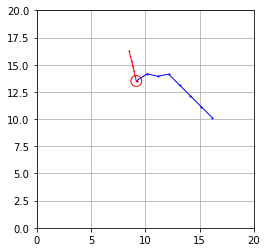

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 0.976327657699585
DEBUG:root:movement: 1.2653698921203613
DEBUG:root:vector 1: [-0.6239939  1.       ]
DEBUG:root:vector 2: [-0.00856972  1.        ]
DEBUG:root:angle: 0.5493059380250832
DEBUG:root:reached goal
DEBUG:root:x: [15.637024, 15.01303, 15.00446, 14.954124]
DEBUG:root:y: [9.947062, 10.947062, 11.947062, 12.716417]
DEBUG:root:goal: [14.55641  12.544965]


done
info {'distance_to_goal': 0.8307402, 'steps_taken': 3, 'previous_state': array([14.954124, 12.716417, 14.55641 , 12.544965, 14.972146, 12.777173],
      dtype=float32), 'new_state': array([14.954124, 12.716417, 14.55641 , 12.544965, 14.972146, 12.777173],
      dtype=float32)}


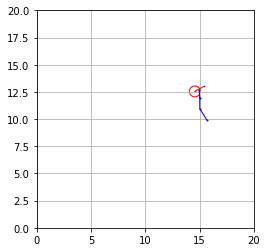

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.411618709564209
DEBUG:root:movement: 1.8326458930969238
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.8265388011932373
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.7999731302261353
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:reached goal
DEBUG:root:x: [14.439161, 13.439161, 12.439161, 11.439161, 10.439161, 9.439161]
DEBUG:root:y: [8.681116, 9.681116, 10.681116, 11.681116, 12.681116, 13.032173]
DEBUG:root:goal: [ 9.215551 13.178012]


done
info {'distance_to_goal': 1.6460854, 'steps_taken': 5, 'previous_state': array([ 9.439161 , 13.032173 ,  9.215551 , 13.178012 ,  9.101435 ,
       13.6403265], dtype=float32), 'new_state': array([ 9.439161 , 13.032173 ,  9.215551 , 13.178012 ,  9.101435 ,
       13.6403265], dtype=float32)}


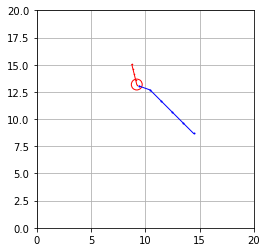

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.3250923156738281
DEBUG:root:movement: 1.7560701370239258
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [0.99999976 1.        ]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.7413721084594727
DEBUG:root:vector 1: [0.99999976 1.        ]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.7169981002807617
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.6339492797851562
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1.        0.8054104]
DEBUG:root:angle: 0.10736685086912146
DEBUG:root:movement: 1.4798994064331055
DEBUG:root:vector 1: [1.        0.8054104]
DEBUG:root:vector 2: [1.         0.16387177]
DEBUG:root:angle: 0.5156030631951087
DEBUG:root:movement: 1.5725939273834229
DEBUG:root:vector 1: [1.         0.16387177]
DEBUG:root:vector 2: [1.        0.6015549]
DEBUG:root:angle: 0.379133753404228
DEBUG:

done
info {'distance_to_goal': 1.7923878, 'steps_taken': 9, 'previous_state': array([11.808248 , 10.218676 , 12.066382 , 10.1035385, 12.541976 ,
       10.12737  ], dtype=float32), 'new_state': array([11.808248 , 10.218676 , 12.066382 , 10.1035385, 12.541976 ,
       10.12737  ], dtype=float32)}


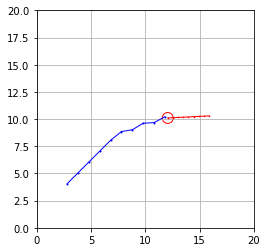

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.2724275588989258
DEBUG:root:movement: 1.4693503379821777
DEBUG:root:vector 1: [1.0000005 1.       ]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0
DEBUG:root:movement: 1.4546666145324707
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.3712213039398193
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1.       0.636703]
DEBUG:root:angle: 0.2184278926138378
DEBUG:root:movement: 1.3731634616851807
DEBUG:root:vector 1: [1.       0.636703]
DEBUG:root:vector 2: [1.        0.6518922]
DEBUG:root:angle: 0.010742239150268305
DEBUG:root:movement: 1.367429256439209
DEBUG:root:vector 1: [1.        0.6518922]
DEBUG:root:vector 2: [1.        0.6557889]
DEBUG:root:angle: 0.0027186357800123547
DEBUG:root:reached goal
DEBUG:root:x: [7.4524035, 8.452404, 9.452404, 10.452404, 11.452404, 12.452404, 13.452404, 14.34491]
DEBUG:root:y: [0.67976665, 1.6797667, 2.6797667, 3.6797667, 

done
info {'distance_to_goal': 0.9102302, 'steps_taken': 7, 'previous_state': array([14.34491  ,  5.658428 , 14.022934 ,  6.0119586, 14.361115 ,
        5.676711 ], dtype=float32), 'new_state': array([14.34491  ,  5.658428 , 14.022934 ,  6.0119586, 14.361115 ,
        5.676711 ], dtype=float32)}


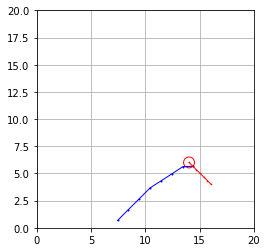

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.408156394958496
DEBUG:root:movement: 1.8682456016540527
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 0.9999995 -1.       ]
DEBUG:root:angle: 0.0
DEBUG:root:movement: 1.867905616760254
DEBUG:root:vector 1: [ 0.9999995 -1.       ]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0
DEBUG:root:movement: 1.8656671047210693
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:reached goal
DEBUG:root:x: [6.917752, 7.917752, 8.917751, 9.917751, 10.917751, 11.378979]
DEBUG:root:y: [11.614452, 10.614452, 9.614452, 8.614452, 7.6144524, 7.354665]
DEBUG:root:goal: [11.28884    7.2191024]


done
info {'distance_to_goal': 1.0054824, 'steps_taken': 5, 'previous_state': array([11.378979 ,  7.354665 , 11.28884  ,  7.2191024, 11.489077 ,
        6.7870574], dtype=float32), 'new_state': array([11.378979 ,  7.354665 , 11.28884  ,  7.2191024, 11.489077 ,
        6.7870574], dtype=float32)}


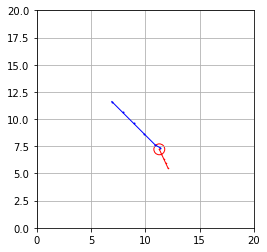

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 0.9990715980529785
DEBUG:root:movement: 1.335230827331543
DEBUG:root:vector 1: [-1.          0.01194954]
DEBUG:root:vector 2: [-1.         -0.18947124]
DEBUG:root:angle: 0.19920057333903202
DEBUG:root:movement: 1.3273935317993164
DEBUG:root:vector 1: [-1.         -0.18947124]
DEBUG:root:vector 2: [-1.          0.04402828]
DEBUG:root:angle: 0.23125146283059803
DEBUG:root:movement: 1.3208168745040894
DEBUG:root:vector 1: [-1.          0.04402828]
DEBUG:root:vector 2: [-1.        -0.3101492]
DEBUG:root:angle: 0.3447413839154447
DEBUG:root:movement: 1.2806613445281982
DEBUG:root:vector 1: [-1.        -0.3101492]
DEBUG:root:vector 2: [-1.         -0.82702255]
DEBUG:root:angle: 0.3902601789713745
DEBUG:root:reached goal
DEBUG:root:x: [11.769919, 10.769919, 9.769919, 8.769919, 7.7699194, 6.7699194, 6.1845217]
DEBUG:root:y: [14.916721, 14.928671, 14.7392, 14.783228, 14.473079, 13.646056, 13.733528]
DEBUG:root:goal: [ 6.6009054 13.558282 ]


done
info {'distance_to_goal': 0.5601491, 'steps_taken': 6, 'previous_state': array([ 6.1845217, 13.733528 ,  6.6009054, 13.558282 ,  6.2719784,
       13.902614 ], dtype=float32), 'new_state': array([ 6.1845217, 13.733528 ,  6.6009054, 13.558282 ,  6.2719784,
       13.902614 ], dtype=float32)}


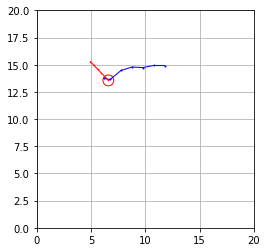

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.116495132446289
DEBUG:root:movement: 1.2820100784301758
DEBUG:root:vector 1: [ 1.0000001 -1.       ]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.2497634887695312
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1.         -0.85244274]
DEBUG:root:angle: 0.07948785421038361
DEBUG:root:movement: 1.248746395111084
DEBUG:root:vector 1: [ 1.         -0.85244274]
DEBUG:root:vector 2: [ 1.         -0.45666695]
DEBUG:root:angle: 0.2775259930464849
DEBUG:root:movement: 1.2553200721740723
DEBUG:root:vector 1: [ 1.         -0.45666695]
DEBUG:root:vector 2: [ 1.         -0.31124878]
DEBUG:root:angle: 0.1266394401540146
DEBUG:root:movement: 1.2454049587249756
DEBUG:root:vector 1: [ 1.         -0.31124878]
DEBUG:root:vector 2: [ 1.        -0.4716587]
DEBUG:root:angle: 0.13897310732862486
DEBUG:root:movement: 1.1954011917114258
DEBUG:root:vector 1: [ 1.        -0.4716587]
DEBUG:root:vector 2: [ 1

done
info {'distance_to_goal': 0.9133621, 'steps_taken': 9, 'previous_state': array([10.029561,  9.745423,  9.763364,  9.621138, 10.015626, 10.025021],
      dtype=float32), 'new_state': array([10.029561,  9.745423,  9.763364,  9.621138, 10.015626, 10.025021],
      dtype=float32)}


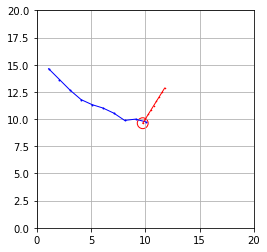

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.2558250427246094
DEBUG:root:movement: 1.5636672973632812
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.5483779907226562
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.523308277130127
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.4724431037902832
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 0.886384 -1.      ]
DEBUG:root:angle: 0.0601569175582639
DEBUG:root:movement: 1.4128313064575195
DEBUG:root:vector 1: [ 0.886384 -1.      ]
DEBUG:root:vector 2: [ 0.9147792 -1.       ]
DEBUG:root:angle: 0.01567847538549344
DEBUG:root:movement: 1.409041166305542
DEBUG:root:vector 1: [ 0.9147792 -1.       ]
DEBUG:root:vector 2: [ 0.22339535 -1.        ]
DEBUG:root:angle: 0.5211341367167456
DEBUG:root:movement: 

done
info {'distance_to_goal': 1.5520751, 'steps_taken': 9, 'previous_state': array([8.844051 , 7.457817 , 8.468569 , 7.3287816, 8.231728 , 6.915667 ],
      dtype=float32), 'new_state': array([8.844051 , 7.457817 , 8.468569 , 7.3287816, 8.231728 , 6.915667 ],
      dtype=float32)}


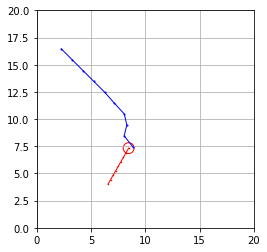

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 0.985407829284668
DEBUG:root:movement: 1.3988375663757324
DEBUG:root:vector 1: [0.43041277 1.        ]
DEBUG:root:vector 2: [0.3456478 1.       ]
DEBUG:root:angle: 0.0736540901418313
DEBUG:root:movement: 1.4313225746154785
DEBUG:root:vector 1: [0.3456478 1.       ]
DEBUG:root:vector 2: [-0.15105724  0.9999995 ]
DEBUG:root:angle: 0.48271608924397025
DEBUG:root:movement: 1.4118995666503906
DEBUG:root:vector 1: [-0.15105724  0.9999995 ]
DEBUG:root:vector 2: [0.15143633 1.        ]
DEBUG:root:angle: 0.30021828308235826
DEBUG:root:movement: 1.4077937602996826
DEBUG:root:vector 1: [0.15143633 1.        ]
DEBUG:root:vector 2: [0.2652464 1.       ]
DEBUG:root:angle: 0.10898278640853504
DEBUG:root:movement: 1.3758797645568848
DEBUG:root:vector 1: [0.2652464 1.       ]
DEBUG:root:vector 2: [0.44347858 1.        ]
DEBUG:root:angle: 0.15814164435297628
DEBUG:root:reached goal
DEBUG:root:x: [7.121443, 7.5518556, 7.8975034, 7.746446, 7.8978825, 8.163

done
info {'distance_to_goal': 1.647332, 'steps_taken': 7, 'previous_state': array([ 8.698349, 12.330122,  8.500308, 12.530394,  8.257521, 12.940042],
      dtype=float32), 'new_state': array([ 8.698349, 12.330122,  8.500308, 12.530394,  8.257521, 12.940042],
      dtype=float32)}


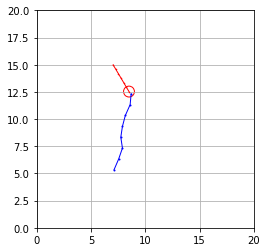

In [19]:

# test prediction
logger.setLevel(logging.DEBUG)

episodes = 10
for episode in range(episodes):
    env.reset()

    while True:
        action, _states = model.predict(env.state)
        obs, rewards, done, info = env.step(action)
        if done:
            print('done')
            print("info", info)
            break
    env.render()

In [20]:
from stable_baselines3.common.evaluation import evaluate_policy

evaluate_policy(model, env, n_eval_episodes=10, render=False)

# TODO render doesn't work

/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.0135269165039062
DEBUG:root:movement: 0.7763936519622803
DEBUG:root:vector 1: [-1.         0.1790657]
DEBUG:root:vector 2: [-1.        -0.2370243]
DEBUG:root:angle: 0.4099170234120799
DEBUG:root:movement: 0.7658658027648926
DEBUG:root:vector 1: [-1.        -0.2370243]
DEBUG:root:vector 2: [-1.         -0.36714745]
DEBUG:root:angle: 0.11913800755618661
DEBUG:root:movement: 0.7638989686965942
DEBUG:root:vector 1: [-1.         -0.36714745]
DEBUG:root:vector 2: [-1.        -0.3930235]
DEBUG:root:angle: 0.022609538022563713
DEBUG:root:reached goal
DEBUG:root:
DEBUG:root:reset
DEBUG:roo

(956.9671060323715, 170.59765622458454)